# **Walmart Sales Forecasting - Kaggle M5 Accuracy**

##### MSBA Class of 2023: Aakriti Aneja, Akshay Rahul, Narae Kang, Niharika Agnihotri, Shweta Chabukswar 
##### Predictive Analytics

In this project, we aim to forecast daily sales for the next 28 days for Walmart. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

**We begin with Data Explotration**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mat_dates
from matplotlib.ticker import FuncFormatter, PercentFormatter
import math
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.2f}'.format)
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
# from fbprophet import Prophet
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import lightgbm as lgb
import xgboost as xgb
import dask.dataframe as dd
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
import gc
import os
from  datetime import datetime, timedelta
import gc
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor #Borrar del modelo

def label(X, categorical_cols):

    for col in categorical_cols:
                 
        le = LabelEncoder()
        #not_null = df[col][df[col].notnull()]
        X[col] = X[col].fillna('nan')
        X[col] = pd.Series(le.fit_transform(X[col]), index=X.index)

    return X

## Reading the Dataset

In [4]:
calendar_df=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")

In [5]:
sales_df=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv")
prices_df=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")

## Data Exploration

In [6]:
print('shape of calendar_df is ',calendar_df.shape)
print('top 2 rows of calendar_df')
calendar_df.head(2)

shape of calendar_df is  (1969, 14)
top 2 rows of calendar_df


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0


In [7]:
print('shape of sales_df is ',sales_df.shape)
print('top 2 rows of sales_df')
sales_df.head(2)

shape of sales_df is  (30490, 1947)
top 2 rows of sales_df


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0


In [8]:
print('shape of prices_df is ',prices_df.shape)
print('top 2 rows of prices_df')
prices_df.head(2)

shape of prices_df is  (6841121, 4)
top 2 rows of prices_df


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


In [9]:
states = len(sales_df['state_id'].unique())
stores = len(sales_df['store_id'].unique())
item_cat = len(sales_df['cat_id'].unique())
depts = len(sales_df['dept_id'].unique())
items = len(sales_df['item_id'].unique())
f'The data comprises for {states} States, {stores} Stores, {item_cat} Item Categories, {depts} Departments, {items} Items'

'The data comprises for 3 States, 10 Stores, 3 Item Categories, 7 Departments, 3049 Items'

**Overall sales from day 1 (Jan 29 2011) to day 1913 (Apr 24 2016) i.e, approximately for 5.5 years:**


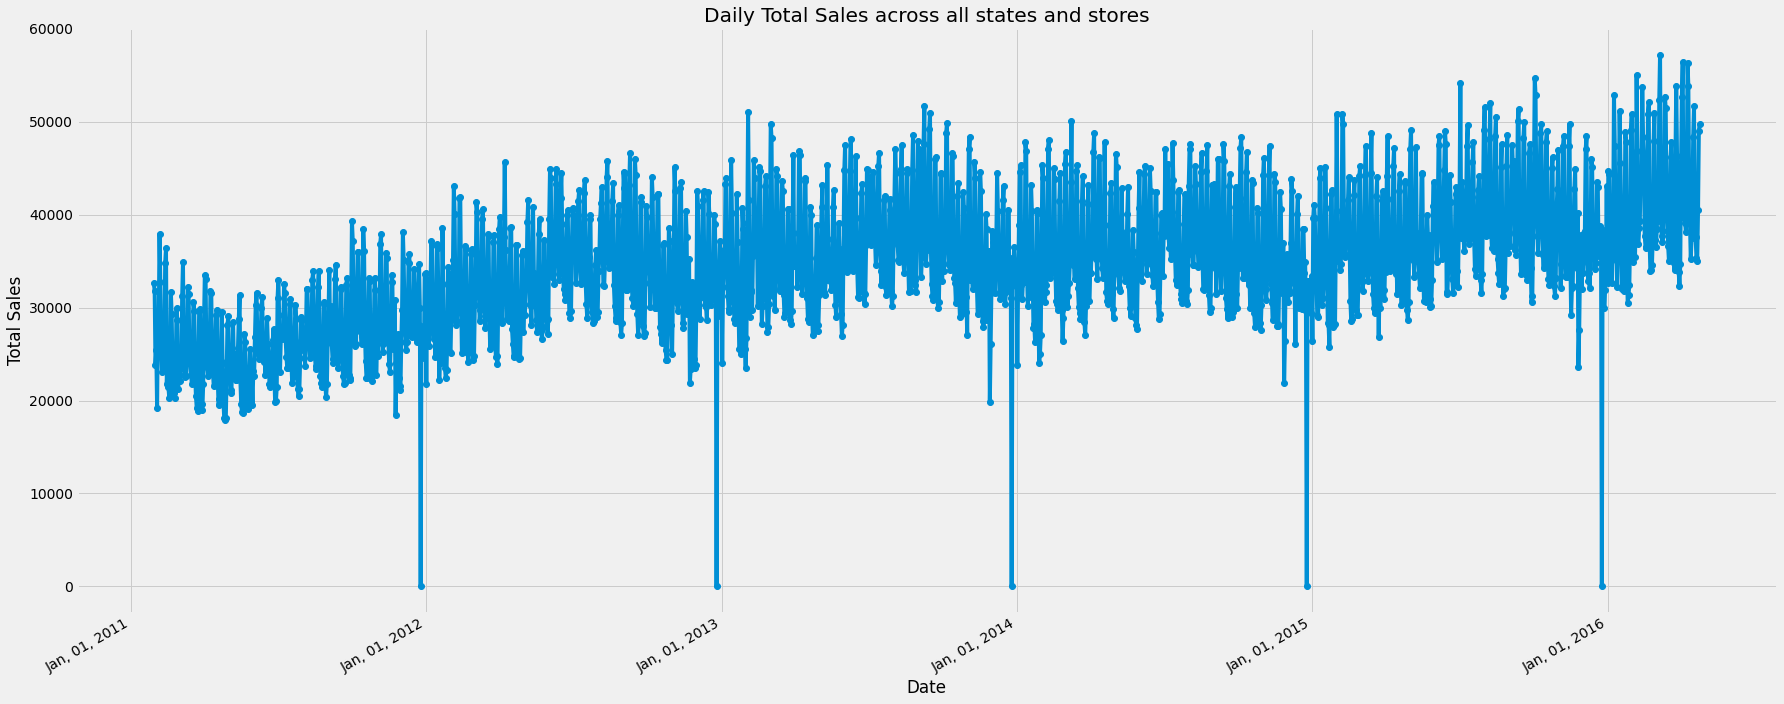

In [11]:

daily_overallsales = sales_df.loc[:,'d_1':'d_1913'].aggregate(['sum'])
daily_overallsales = daily_overallsales.T.reset_index()
daily_overallsales.rename(columns={'sum':'Total_Sales','index':'d'}, inplace=True)
daily_overallsales = daily_overallsales.merge(calendar_df,on='d',how='left')
daily_overallsales = daily_overallsales[['date','Total_Sales']]
daily_overallsales['date'] = pd.to_datetime(daily_overallsales['date'])
daily_dates = daily_overallsales['date']
daily_totalSales = daily_overallsales['Total_Sales']

""" Plot of Date Vs Total_sales """
plt.style.use('fivethirtyeight')
plt.plot_date(daily_dates,daily_totalSales,linestyle='solid')
plt.gcf().autofmt_xdate()
date_format = mat_dates.DateFormatter('%b, %d, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().set_size_inches(25, 10)
plt.title('Daily Total Sales across all states and stores')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

**Overall sales for each year from 2011-2016:**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  if sys.path[0] == "":


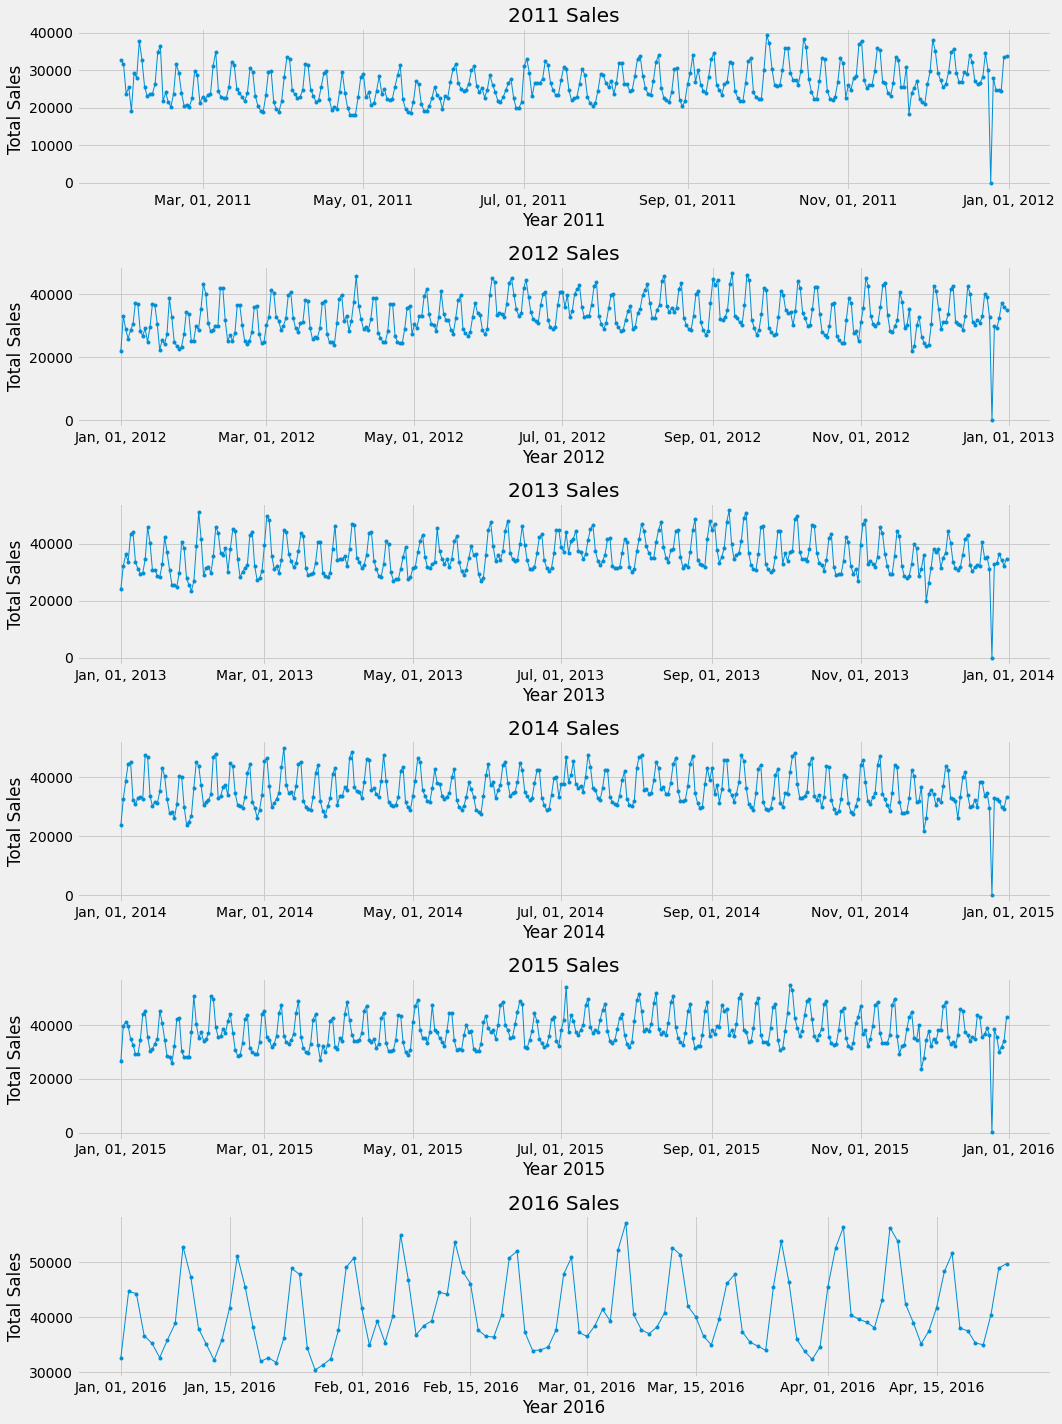

In [13]:

daily_overallsales['year'] = daily_overallsales['date'].dt.year
daily_overallsales_grp = daily_overallsales.groupby(['year'])
gf = daily_overallsales_grp.groups

""" plot of Years Vs Total_sales """
gf_val_lst = list(gf.values())
date_format = mat_dates.DateFormatter('%b, %d, %Y')
fig = plt.figure(figsize=(15, 20))
for i in range(6):
    ax = fig.add_subplot(6,1,i+1)
    plt.plot_date(daily_overallsales.iloc[gf_val_lst[i]]['date'],daily_overallsales.iloc[gf_val_lst[i]]['Total_Sales'],linestyle='solid',linewidth=1,marker='.')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gca().set_title(str(2011+i)+ ' Sales')
    plt.gca().set_xlabel('Year '+str(2011+i))
    plt.gca().set_ylabel('Total Sales')
plt.tight_layout()
plt.show()

**Global monthly seasonality sales:**

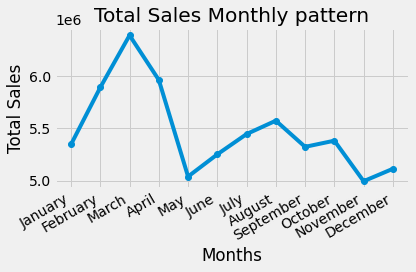

In [14]:
daily_overallsales['month']=daily_overallsales['date'].dt.month_name()
daily_overallsales_gpm = daily_overallsales.groupby('month').agg({'Total_Sales':'sum'}).reset_index()

#reference: https://stackoverflow.com/questions/40816144/pandas-series-sort-by-month-index
months_order = list(daily_overallsales['date'].dt.month_name().unique())
daily_overallsales_gpm.index = pd.CategoricalIndex(daily_overallsales_gpm.month, categories=months_order, ordered=True)
daily_overallsales_gpm = daily_overallsales_gpm.sort_index()
daily_overallsales_gpm.reset_index(drop=True,inplace=True)

"""Plot of Months Vs Total Sales"""
plt.plot_date(daily_overallsales_gpm['month'],daily_overallsales_gpm['Total_Sales'],linestyle='solid')
plt.gcf().autofmt_xdate()
plt.title('Total Sales Monthly pattern')
plt.xlabel('Months')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

Sales show an upward trend from Dec - March considering the holiday period.

**Global Weekly Seasonality Sales:**

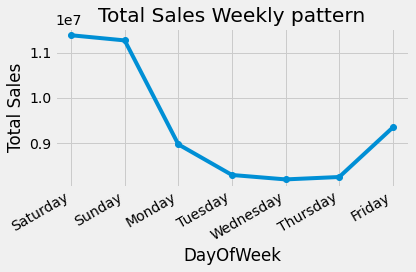

In [15]:
daily_overallsales['day_name']=daily_overallsales['date'].dt.day_name()
daily_overallsales_gpwd = daily_overallsales.groupby('day_name').agg({'Total_Sales':'sum'}).reset_index()

#reference: https://stackoverflow.com/questions/40816144/pandas-series-sort-by-month-index
day_name_order = list(daily_overallsales['date'].dt.day_name().unique())
daily_overallsales_gpwd.index = pd.CategoricalIndex(daily_overallsales_gpwd.day_name, categories=day_name_order, ordered=True)
daily_overallsales_gpwd = daily_overallsales_gpwd.sort_index()
daily_overallsales_gpwd.reset_index(drop=True,inplace=True)

"""Plot of Dayofweek Vs Total Sales"""
plt.plot_date(daily_overallsales_gpwd['day_name'],daily_overallsales_gpwd['Total_Sales'],linestyle='solid')
plt.gcf().autofmt_xdate()
plt.title('Total Sales Weekly pattern')
plt.xlabel('DayOfWeek')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

Above trend shows sales are higher during weekend (Fri to Sun) than the rest of the week.

In [20]:
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1],y_list[i-1], ha="center")

**Sales Proportion from each store:**

In [16]:

sales_store_grp = sales_df.groupby('store_id')
sales_store_grp_idx = list(sales_store_grp.groups.values())
stores_ky = list(sales_store_grp.groups.keys())
stores = []
store_sales = []
for i in range(len(stores_ky)):
    stores.append(stores_ky[i])
    store_df = sales_df.iloc[sales_store_grp_idx[i]]
    store_sales.append(int(store_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))



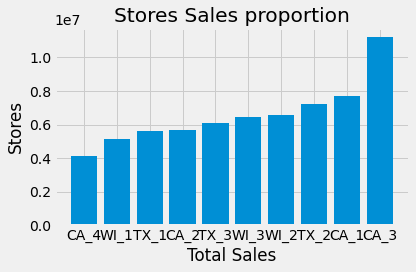

In [17]:

stores = list(np.asarray(stores)[np.argsort(np.asarray(store_sales))])
store_sales = list(np.asarray(store_sales)[np.argsort(np.asarray(store_sales))])
plt.bar(stores,store_sales)
# add_value_label(,store_sales/100000)
plt.title('Stores Sales proportion')
plt.xlabel('Total Sales')
plt.ylabel('Stores')
plt.tight_layout()
plt.show()

As we can see, there is variance in stores sales in diferent states.

**Sales Proportion from each product category:**

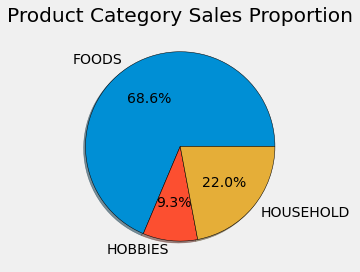

In [18]:
""" Here we get sales Proportion from each product category """
sales_cat_grp = sales_df.groupby('cat_id')
sales_cat_grp_idx = list(sales_cat_grp.groups.values())
cat_ky = list(sales_cat_grp.groups.keys())
prod_cats = []
prod_cats_sales = []
for i in range(len(cat_ky)):
    prod_cats.append(cat_ky[i])
    cat_df = sales_df.iloc[sales_cat_grp_idx[i]]
    prod_cats_sales.append(int(cat_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))

"""plot of sales Proportion from each product category"""
plt.pie(prod_cats_sales,labels=prod_cats,shadow=True,
        autopct = '%1.1f%%', wedgeprops={'edgecolor':'black'})
plt.title('Product Category Sales Proportion')
plt.tight_layout()
plt.show()

Most of the sales comes from Food Category.

**Sales Proportion from Each Category:**

In [24]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [25]:
sales_cat_grp = sales_df.groupby('cat_id')
sales_cat_grp_idx = list(sales_cat_grp.groups.values())
cat_ky = list(sales_cat_grp.groups.keys())
cats = []
cat_sales = []
for i in range(len(cat_ky)):
    cats.append(cat_ky[i])
    cat_df = sales_df.iloc[sales_cat_grp_idx[i]]
    cat_sales.append(int(dept_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))

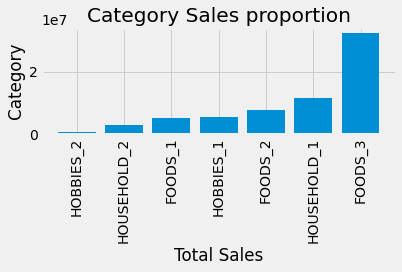

In [28]:
"""plot of sales Proportion from each category"""
cats = list(np.asarray(depts)[np.argsort(np.asarray(dept_sales))])
cat_sales = list(np.asarray(dept_sales)[np.argsort(np.asarray(dept_sales))])
plt.bar(cats,cat_sales)
plt.title('Category Sales proportion')
plt.xlabel('Total Sales')
plt.xticks(rotation = 90)
plt.ylabel('Category')
plt.tight_layout()
plt.show()

A Category-Store wise distribution shows that stores perform different for same categories. For example, Within Foods, Store 3 performs much better than Store 1 & 2.

**Number of days with and without events:**

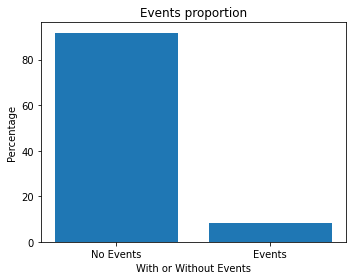

In [7]:

df = calendar_df[['event_name_1']]
no_event_per = ((len(df) - int(df.count()))/len(df))*100
event_per = (int(df.count())/len(df))*100
event_lst = [('No Events',no_event_per),('Events',event_per)]
events = [x[0] for x in event_lst]
events_count = [x[1] for x in event_lst]

plt.figure(figsize=(5,4))
plt.bar(events,events_count)
plt.title('Events proportion')
plt.xlabel('With or Without Events')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

**We have 4 types of events: Religious, National, Cultural and Sporting**

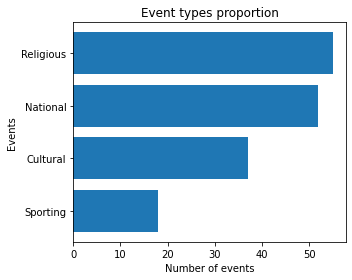

In [8]:

event_lst = [tuple(x) for x in calendar_df[['event_type_1']].value_counts().reset_index().values]
events = [x[0] for x in event_lst]
events.reverse()
events_count = [x[1] for x in event_lst]
events_count.reverse()
plt.figure(figsize=(5,4))
plt.barh(events,events_count)
plt.title('Event types proportion')
plt.xlabel('Number of events')
plt.ylabel('Events')
plt.tight_layout()
plt.show()

**Product Category by Year:**

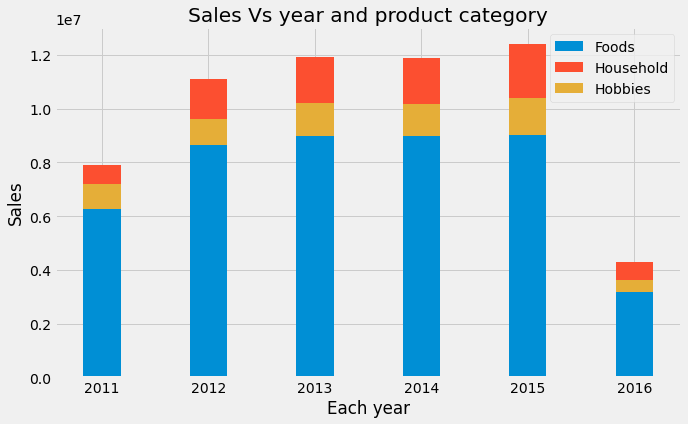

In [9]:
sales_cat = {}
sales_cat_grp = sales_df.groupby('cat_id')
sales_cat_grp_idx = list(sales_cat_grp.groups.values())
cat_ky = list(sales_cat_grp.groups.keys())
for i in range(len(cat_ky)):
    sales_cat_df = pd.melt(sales_df.iloc[sales_cat_grp_idx[i]].loc[:,'d_1':'d_1913'],var_name='d',value_name='sales').merge(calendar_df,on='d',how='left')
    sales_cat_yr_grp = sales_cat_df.groupby('year').groups
    sales_cat_yr_idx = list(sales_cat_yr_grp.values())
    sales_cat_yr_ky = list(sales_cat_yr_grp.keys())
    sales_cat[cat_ky[i]] = {}
    for j in range(len(sales_cat_yr_ky)):
        sales_cat[cat_ky[i]][sales_cat_yr_ky[j]] = sales_cat_df.iloc[sales_cat_yr_idx[j]]['sales'].sum()

"""plot of the sales proportion of each product category for each year """

N = 6
FOODS_sales = list(sales_cat['FOODS'].values())
HOBBIES_sales = list(sales_cat['HOBBIES'].values())
HOUSEHOLD_sales = list(sales_cat['HOUSEHOLD'].values())

ind = np.arange(N)    
width = 0.35   

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
p1 = plt.bar(ind, FOODS_sales, width)
p2 = plt.bar(ind, HOUSEHOLD_sales, width,bottom=FOODS_sales)
p3 = plt.bar(ind, HOBBIES_sales, width,bottom=FOODS_sales)

plt.xlabel('Each year')
plt.ylabel('Sales')
plt.title('Sales Vs year and product category')
plt.xticks(ind, (2011, 2012, 2013, 2014, 2015, 2016))
plt.legend((p1[0], p2[0], p3[0]), ('Foods', 'Household','Hobbies'))

plt.show()

Overall, there has been an increase in sales of all categories year-on-year from 2011 to 2016.

## Feature Engineering

### Calendar Level Features to capture seasonality

We start this section by loading the relevant packages and using the calendar file as the first input file. 

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [21]:
calendar_data = pd.read_csv('calendar.csv')

We see that there are multiple NA's - which is expected as it is possible not all days have an event. However we want to update the corresponding day to another value - we do that with 'No event'

In [22]:
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [23]:
calendar_data['event_type_1'].fillna('No event', inplace=True)
calendar_data['event_type_2'].fillna('No event', inplace=True)

We also notice that the number of distinct events observed in the event types - is of only four. Hence we proceed to create one hot encoded columns of the same. We also combine the two seperate columns into one. Finally, we have four columns which tell us if the event is a holiday for that type (if 1)

In [24]:
calendar_data = pd.get_dummies(calendar_data,columns = ['event_type_1','event_type_2'])

In [25]:
calendar_data['Religious_Holiday'] = calendar_data['event_type_1_Religious'] + calendar_data['event_type_2_Religious']
calendar_data['Cultural_Holiday'] = calendar_data['event_type_1_Cultural'] + calendar_data['event_type_2_Cultural']
calendar_data['Sporting_Holiday'] = calendar_data['event_type_1_Sporting']
calendar_data['National_Holiday'] = calendar_data['event_type_1_National']

We can now take a look at the first few records again.

In [26]:
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_name_2,snap_CA,...,event_type_1_No event,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_No event,event_type_2_Religious,Religious_Holiday,Cultural_Holiday,Sporting_Holiday,National_Holiday
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,0,...,1,0,0,0,1,0,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,0,...,1,0,0,0,1,0,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,0,...,1,0,0,0,1,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,1,...,1,0,0,0,1,0,0,0,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,1,...,1,0,0,0,1,0,0,0,0,0


We will drop all the columns we had created with the one hot encoding step

In [27]:
calendar_data = calendar_data.drop(columns = ['event_type_1_Cultural', 'event_type_1_National',
       'event_type_1_No event', 'event_type_1_Religious',
       'event_type_1_Sporting', 'event_type_2_Cultural',
       'event_type_2_No event', 'event_type_2_Religious'],axis = 1)

We create a column to check if the day is a weekend or not - we feel this may have an impact on the sales 

In [28]:
calendar_data['weekend'] = 0
calendar_data.loc[((calendar_data['wday'] == 1) | (calendar_data['wday'] == 2)),'weekend'] = 1

We now add features based on the date - to do this we first coerce the date to a pandas date time field.

In [29]:
calendar_data['date'] = pd.to_datetime(calendar_data['date'], errors='coerce')

We then create three possibilites based on the month- month start,end and the quarter it belongs to

In [30]:
calendar_data['Month_End'] = 0
calendar_data.loc[calendar_data['date'].dt.day.astype('int').isin([25,26,27,28,29,30,31]),'Month_End'] = 1

In [31]:
calendar_data['Month_Start'] = 0
calendar_data.loc[calendar_data['date'].dt.day.astype('int').isin([1,2,3,4,5,6,7]),'Month_Start'] = 1

In [32]:
calendar_data['Quarter'] = 0
calendar_data.loc[calendar_data['date'].dt.month.astype('int').isin([1,2,3]),'Quarter'] = 1
calendar_data.loc[calendar_data['date'].dt.month.astype('int').isin([4,5,6]),'Quarter'] = 2
calendar_data.loc[calendar_data['date'].dt.month.astype('int').isin([7,8,9]),'Quarter'] = 3
calendar_data.loc[calendar_data['date'].dt.month.astype('int').isin([10,11,12]),'Quarter'] = 4

In [33]:
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,Religious_Holiday,Cultural_Holiday,Sporting_Holiday,National_Holiday,weekend,Month_End,Month_Start,Quarter
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,0,0,0,0,0,0,0,1,1,0,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,0,0,0,0,0,0,0,1,1,0,1
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,0,0,0,0,0,0,0,0,1,0,1
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,1,1,0,0,0,0,0,0,0,1,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,1,0,1,0,0,0,0,0,0,1,1


From our EDA - we notice that there are few high and low spending months. We categorize the same next as boolean values depending on the month.

In [34]:
calendar_data['High_Spending_Month'] = 0
calendar_data.loc[calendar_data['date'].dt.month.astype('int').isin([3,4,5]),'High_Spending_Month'] = 1

In [35]:
calendar_data['Low_Spending_Month'] = 0
calendar_data.loc[calendar_data['date'].dt.month.astype('int').isin([6,11,12]),'Low_Spending_Month'] = 1

Finally we clean up the columns by removing columns we have already used.

In [36]:
calendar_data = calendar_data.drop(columns = ['event_name_1','event_name_2','date','weekday','wday','year'],axis = 1)

In [37]:
calendar_data.head()

,wm_yr_wk,month,d,snap_CA,snap_TX,snap_WI,Religious_Holiday,Cultural_Holiday,Sporting_Holiday,National_Holiday,weekend,Month_End,Month_Start,Quarter,High_Spending_Month,Low_Spending_Month
0,11101,1,d_1,0,0,0,0,0,0,0,1,1,0,1,0,0
1,11101,1,d_2,0,0,0,0,0,0,0,1,1,0,1,0,0
2,11101,1,d_3,0,0,0,0,0,0,0,0,1,0,1,0,0
3,11101,2,d_4,1,1,0,0,0,0,0,0,0,1,1,0,0
4,11101,2,d_5,1,0,1,0,0,0,0,0,0,1,1,0,0


We write this file to a new CSV and then we will use this file across our feature engineering process.

In [38]:
calendar_data.to_csv('Calendar_Data_Clean.csv',index = False)

###  Time Series Features

In this section we focus on generating more features - but this time with a focus on time series. We first load the relevant packages.  

In [1]:
import numpy as np 
import pandas as pd

We then read the input files and display the first few records to read the format. Note that we are using the calendar data with the new features we created - instead of using the format given to us.

In [2]:
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

In [3]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
sales_data = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')

In [5]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [8]:
calendar = pd.read_csv('/kaggle/input/calendar/Calendar_Data_Clean.csv')

In [9]:
calendar.head()

,wm_yr_wk,month,d,snap_CA,snap_TX,snap_WI,Religious_Holiday,Cultural_Holiday,Sporting_Holiday,National_Holiday,weekend,Month_End,Month_Start,Quarter,High_Spending_Month,Low_Spending_Month
0,11101,1,d_1,0,0,0,0,0,0,0,1,1,0,1,0,0
1,11101,1,d_2,0,0,0,0,0,0,0,1,1,0,1,0,0
2,11101,1,d_3,0,0,0,0,0,0,0,0,1,0,1,0,0
3,11101,2,d_4,1,1,0,0,0,0,0,0,0,1,1,0,0
4,11101,2,d_5,1,0,1,0,0,0,0,0,0,1,1,0,0


We use a downcast function. This is very useful to help ensure that we do not use more RAM - and objects where possible take the minimum amount of space required in our workflow. 

In [10]:
def downcast(df):
    
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i,t in enumerate(types):

        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')

    return df  

We use the above function across all our input files

In [11]:
sell_prices = downcast(sell_prices)

In [12]:
calendar = downcast(calendar)

We notice from our time series that there is a lot of variation across the first few records. Further we also faced issues with both performance in terms of results as well as computing when we consider all the records - hence we drop the first 250 days in our process. To do this we consider to create a list of all values as we need ranging from 1 to 250

In [13]:
d_li = []
for i in range(1,250):
    d_li.append('d_' + str(i))

We drop these columns

In [14]:
sales_data = sales_data.drop(columns = d_li,axis = 1)

We now add the columns we need from 1942-1970 days and impute them with a value of 0. These will be the values from our evaluation phase - and treated as unknown.

In [15]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales_data[col] = 0

In [16]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_250,d_251,d_252,d_253,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,4,2,2,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,1,1,3,...,0,0,0,0,0,0,0,0,0,0


In [17]:
sales_data = downcast(sales_data)

We can now melt or pivot down the data at day level - considering all the features we have.

In [18]:
sales_data =pd.melt(sales_data,id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],var_name='d',value_name='demand')

In [19]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_250,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_250,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_250,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_250,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_250,0


We now focus on creating time series features below. We update the datatype of days to int by removing the prefix in the column earlier - now that we have it at row level.

In [20]:
sales_data['d'] = sales_data['d'].str.replace('d_','').astype('int')

We consider creating lag features for 28-30 days. We also create two sets of rolling window features - with a window of size 7 and 28 for values of 28 and 30 days. 

Lag features are values at prior timesteps that are considered useful because they are created on the assumption that what happened in the past can influence or contain a sort of intrinsic information about the future.

In the case of a rolling window, the size of the window is constant while the window slides as we move forward in time.The idea behind the expanding window feature is that it takes all the past values into account.

In [21]:
sales_data['lag_28'] = sales_data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
sales_data['lag_29'] = sales_data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
sales_data['lag_30'] = sales_data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
sales_data['rolling_mean_7_28']   = sales_data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
sales_data['rolling_std_7_28']    = sales_data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
sales_data['rolling_mean_30_28']  = sales_data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
sales_data['rolling_std_30_28']  = sales_data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())

We follow the same for rolling means 90 and 180 days with 28 days as the size of the window

In [22]:
sales_data['rolling_mean_90_28']  = sales_data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
sales_data['rolling_mean_180_28'] = sales_data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())

In [23]:
sales_data = downcast(sales_data)

We now update our calendar data - as we try to merge with the dataframe containing the sales value above. The first step is updating the column containing days as seen earlier in our sales dataframe.

We then merge on the same column. We do not write into a new dataframe to enable us to save memory.

In [24]:
calendar['d'] = calendar['d'].str.replace('d_','').astype('int')

In [25]:
sales_data = pd.merge(sales_data,calendar, on = ['d'],how = 'left')

In [26]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_28,lag_29,...,Religious_Holiday,Cultural_Holiday,Sporting_Holiday,National_Holiday,weekend,Month_End,Month_Start,Quarter,High_Spending_Month,Low_Spending_Month
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,0,1,4,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,0,1,4,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,0,1,4,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,0,1,4,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,0,1,4,0,0


We then merge on the selling prices as well. This time we decide to merge on an extended set of keys.

In [27]:
sales_data = pd.merge(sales_data,sell_prices,on = ['item_id','store_id','wm_yr_wk'],how = 'left')

In [28]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_28,lag_29,...,Cultural_Holiday,Sporting_Holiday,National_Holiday,weekend,Month_End,Month_Start,Quarter,High_Spending_Month,Low_Spending_Month,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,1,4,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,1,4,0,0,3.970703
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,1,4,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,1,4,0,0,4.339844
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,0,0,0,1,4,0,0,2.480469


We also noticed that there were a number of missing values in the sell prices file. To overcome this we want to impute the values with the mean. However, taking a strict mean across the column would not be correct as we have a lot of variation in price as well. 

Hence we decide to take mean at item and store level across the weeks. This will act as the level where we impute data for our prices

In [29]:
mean_prices = sell_prices.groupby(['item_id','store_id'])['sell_price'].mean().reset_index()

We again merge the data - this time forcing it on the same index as the level we had created the data. We then follow it up by updating the NA's with the same value in the row with the mean value. 

In [30]:
sales_data = pd.merge(sales_data,mean_prices,on = ['item_id','store_id'],how = 'left')

In [31]:
sales_data['sell_price_x'].fillna(sales_data['sell_price_y'],inplace = True)

In [32]:
sales_data.drop(columns = ['sell_price_y','wm_yr_wk'],inplace = True)

One interesting feature we came across during our analysis is the method to incorporate - change over time. We decided to use the same. 

The reasoning behind incorporating the change would be that there are variations in price which can cause change in demand as well - both price and demand go hand in hand. Hence it would be ideal to consider a situation where we include this change as a feature too - similar to the feature included for demand lags above

We extend to include mean and standard deviation as considering only mean might affect outliers. We have taken the values at one week and one year for the same.

In [33]:
sales_data['lag_price_1'] = sales_data.groupby(['id'])['sell_price_x'].transform(lambda x: x.shift(7))
sales_data['price_change_1'] = (sales_data['lag_price_1'] - sales_data['sell_price_x']) / (sales_data['lag_price_1'])

In [34]:
sales_data['rolling_price_max_365_1'] = sales_data.groupby(['id'])['sell_price_x'].transform(lambda x: x.shift(1).rolling(365).max())
sales_data['price_change_365'] = (sales_data['rolling_price_max_365_1'] - sales_data['sell_price_x']) / (sales_data['rolling_price_max_365_1'])

In [35]:
sales_data['rolling_price_std_t7'] = sales_data.groupby(['id'])['sell_price_x'].transform(lambda x: x.rolling(7).std())
sales_data['rolling_price_std_t30'] = sales_data.groupby(['id'])['sell_price_x'].transform(lambda x: x.rolling(30).std())
sales_data.drop(['rolling_price_max_365_1', 'lag_price_1'], inplace = True, axis = 1)

As our final step - we decided to consider change in revenue as well. By considering both the change in price and revenue over time - we can get a better estimate of the demand too. 

The method to create the features is exactly the same as the ones we saw earlier. We extend to include mean and standard deviation here as well.

In [37]:
sales_data['revenue'] = sales_data['demand'] * sales_data['sell_price_x']
sales_data['lag_revenue_t1'] = sales_data.groupby(['id'])['revenue'].transform(lambda x: x.shift(28))
sales_data['rolling_revenue_std_t28'] = sales_data.groupby(['id'])['lag_revenue_t1'].transform(lambda x: x.rolling(28).std())
sales_data['rolling_revenue_mean_t28'] = sales_data.groupby(['id'])['lag_revenue_t1'].transform(lambda x: x.rolling(28).mean())
sales_data.drop(['revenue'],axis=1,inplace=True)

Once we have all the features - we write them into a pickle file. This will take up less space and we can experiment with our features and modelling - and spend less time running this notebook in the future.

In [38]:
sales_data.to_pickle('final_data.pkl')

In [39]:
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_28,lag_29,...,High_Spending_Month,Low_Spending_Month,sell_price_x,price_change_1,price_change_365,rolling_price_std_t7,rolling_price_std_t30,lag_revenue_t1,rolling_revenue_std_t28,rolling_revenue_mean_t28
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,8.281250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,3.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,2.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,4.339844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,2.480469,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Generating a link to download in Kaggle. 

**Team: Note that this link does not work outside Kaggle.**

In [40]:
import os
os.chdir(r'/kaggle/working')

In [41]:
from IPython.display import FileLink
FileLink(r'final_data.pkl')

/kaggle/working/final_data.pkl

## Model Exploration

We proceed with model exploration. Multiple modeling techniques are available in the industry that can be used for sales forecasting 

### ARIMA


- To get an idea of the modeling, we will try to predict result using Time series

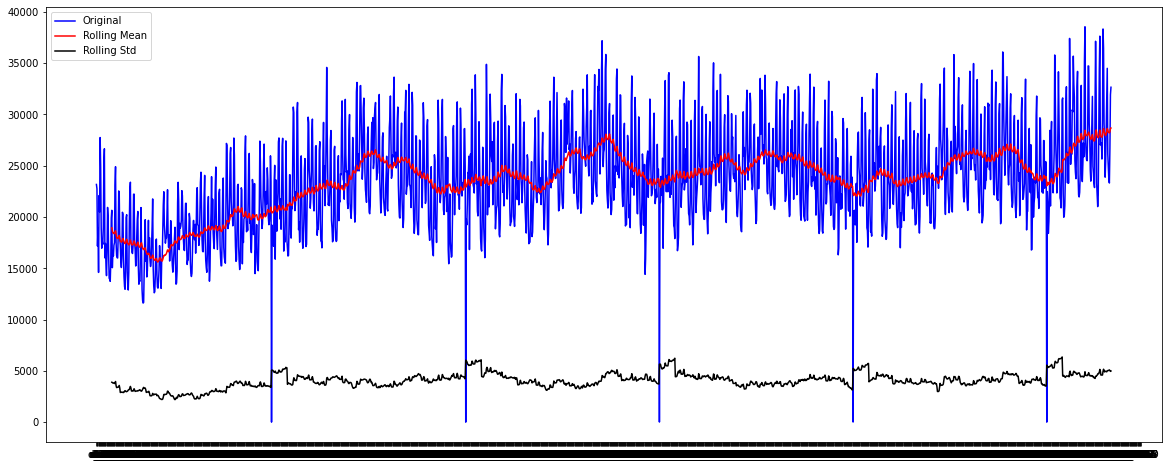

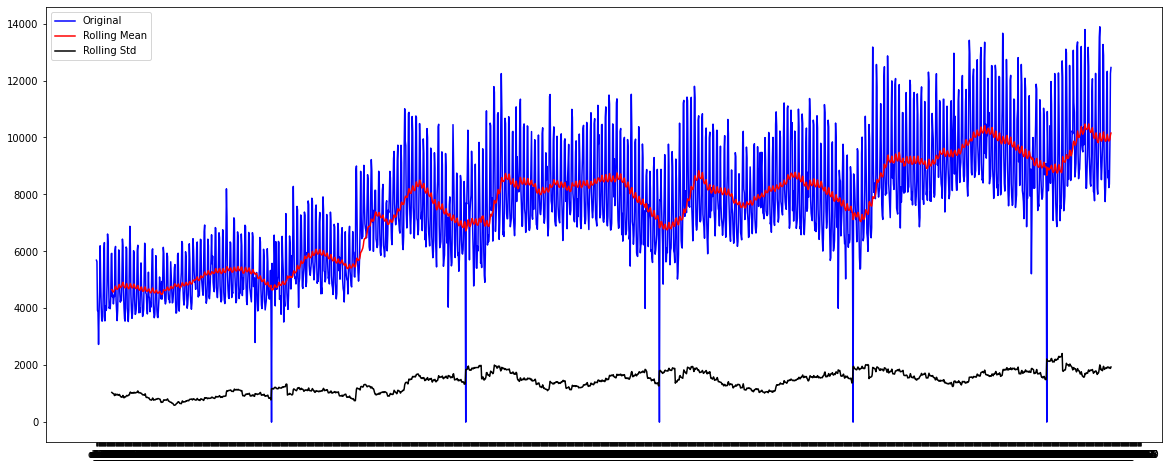

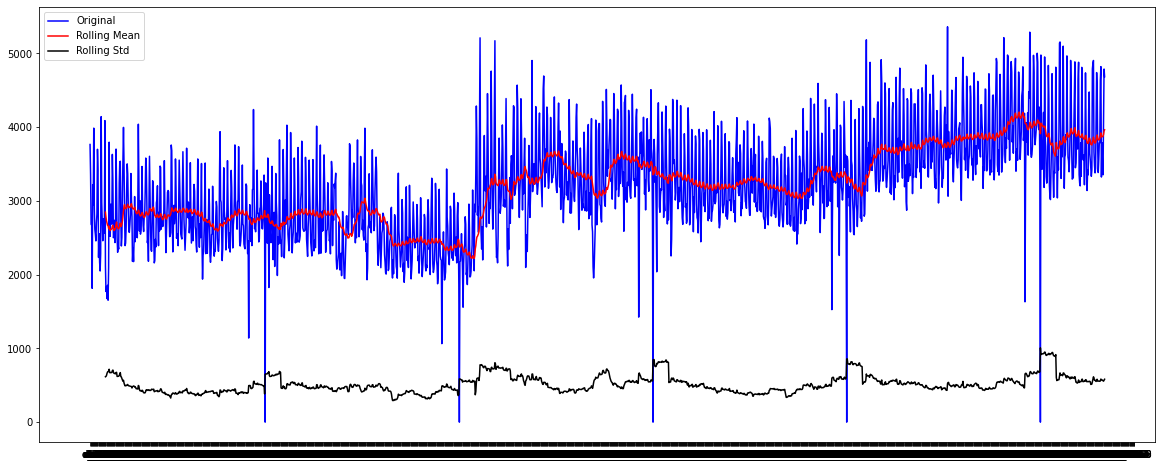

In [25]:
def plot_timeseries_stat(timeseries):
    rollingMean = timeseries.rolling(window=30,center=False).mean()
    rollingStd = timeseries.rolling(window=30,center=False).std()
    plt.figure(figsize=(20,8))
    ori = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rollingMean,color='red',label='Rolling Mean')
    std = plt.plot(rollingStd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

plot_timeseries_stat(total_sales_OverCalendar['FOODS'])
plot_timeseries_stat(total_sales_OverCalendar['HOUSEHOLD'])
plot_timeseries_stat(total_sales_OverCalendar['HOBBIES'])

In [27]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
import math


A stationary time series is one whose properties do not depend on the time at which the series is observed. 
 - check if the time series is stationary 

In [28]:
# Define the functin to check the stationary 
def test_stationarityDF(timeseries): ##Dickey-Fuller Test
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','No of Observesations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [29]:
food_Series = total_sales_OverCalendar['FOODS']
# impute the NA value of the null value of the food_series as a mean
food_Series.fillna(food_Series.mean(),inplace=True)
# test the stationary of the time_series
test_stationarityDF(food_Series)

Test Statistic                 -2.361519
p-value                         0.152893
#Lags Used                     26.000000
No of Observesations Used    1942.000000
Critical Value (1%)            -3.433722
Critical Value (5%)            -2.863029
Critical Value (10%)           -2.567563
dtype: float64


> We can observe that Test Statistic(p-value) is not below the 1% of the Critical value (0.153) So,Series is not stationary.

#### 30 days moving average

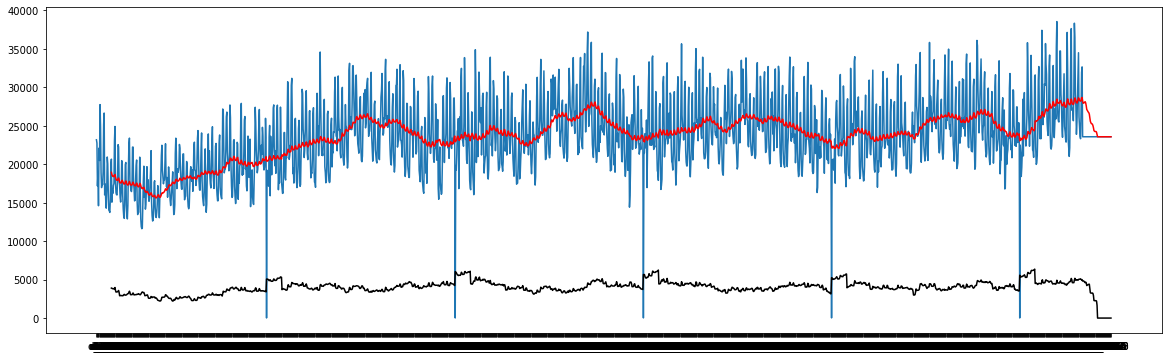

In [30]:
# mean of the 30days window
movingAverage = food_Series.rolling(window=30).mean()
# standard deviation of the 30day window
movingSTD = food_Series.rolling(window=30).std()
plt.figure(figsize=(20,6))
plt.plot(food_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

#### Make stationarry

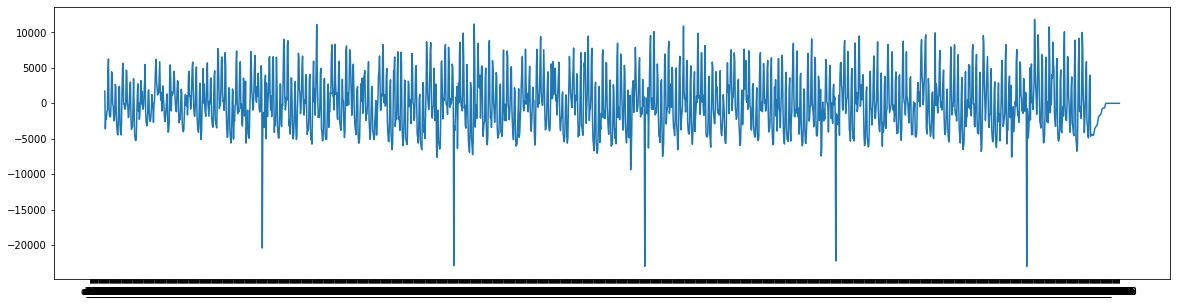

Test Statistic                -8.25633
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1942.00000
Critical Value (1%)           -3.43372
Critical Value (5%)           -2.86303
Critical Value (10%)          -2.56756
dtype: float64


In [31]:
foodSeriesDiff = food_Series-movingAverage
plt.figure(figsize=(20,5))
plt.plot(foodSeriesDiff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
foodSeriesDiff.fillna(foodSeriesDiff.mean(),inplace=True)
test_stationarityDF(foodSeriesDiff)

We can observe that Test Statistic is way less than 1% of critical value. So, we can conculde that the above Series is 99% stationary.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


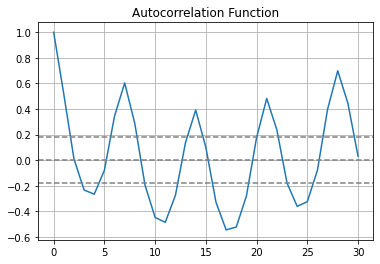

In [32]:
plt.plot(np.arange(0,31,1),acf(foodSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.grid()
plt.show()

Correlation function cross upper confident value between 1 and 2. Hence chose 2 as p for ARIMA

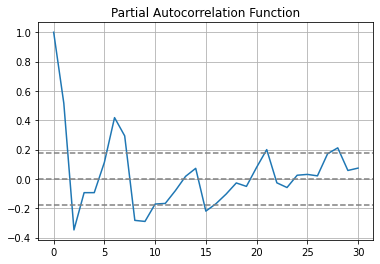

In [33]:
plt.plot(np.arange(0,31,1),pacf(foodSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.grid()
plt.show()

Partial Autocorrelation function drop to 0 when value is between 1 and 2. choose 2 as q value



/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


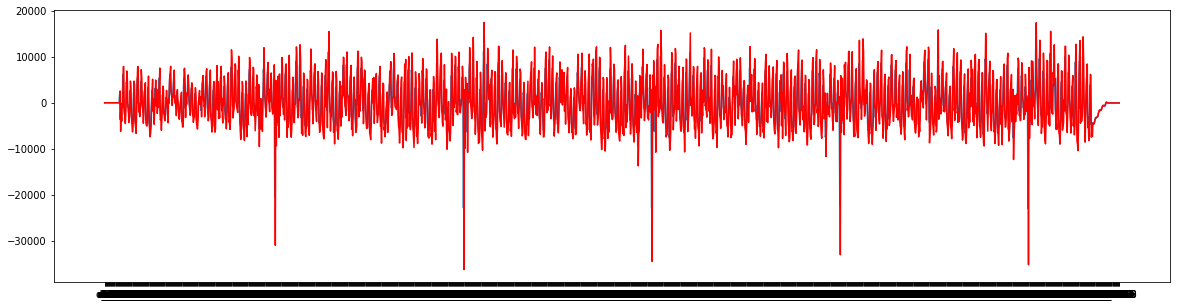

In [34]:
model = ARIMA(foodSeriesDiff,order=(2,2,0))
# results_ARIMA = model.fit(disp=-1)
results_ARIMA = model.fit()

plt.figure(figsize=(20,5))
plt.plot(foodSeriesDiff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.show()

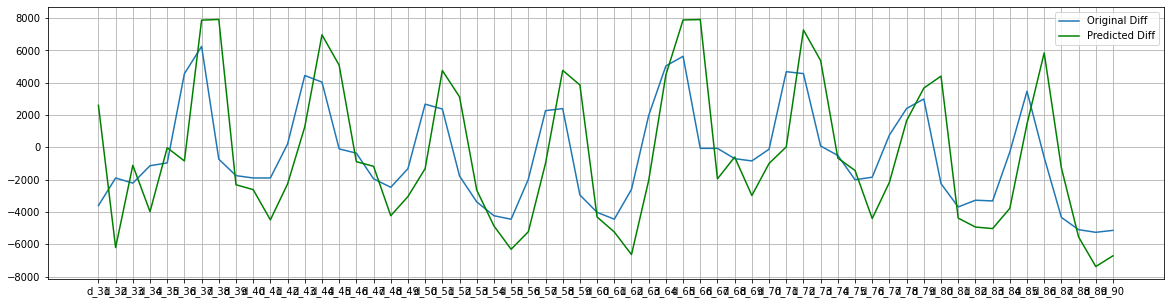

In [36]:
#Plot a portion of data to clear visulization
plt.figure(figsize=(20,5))
ori = plt.plot(foodSeriesDiff.iloc[30:90],label='Original Diff')
#plt.plot(results_ARIMA.fittedvalues.iloc[0:60],color='red')
#plt.plot(results_ARIMA.fittedvalues.iloc[0:60].cumsum(),color='black')
##ARIMA order is 2. show results lags 2 values
#shfited['predicShfited2'] = pd.Series(results_ARIMA.fittedvalues,copy=True)
shfited = pd.DataFrame({'predicShfited2':pd.Series(results_ARIMA.fittedvalues,copy=True),'day':foodSeriesDiff.index[0:1969]})
shfited = shfited.set_index('day')
pre = plt.plot(shfited['predicShfited2'].iloc[30:90],color='green',label='Predicted Diff')
#pre = plt.plot(results_ARIMA.fittedvalues.iloc[0:60],color='green',label='Predicted Diff')
plt.legend(loc='best')
plt.grid()
plt.show()

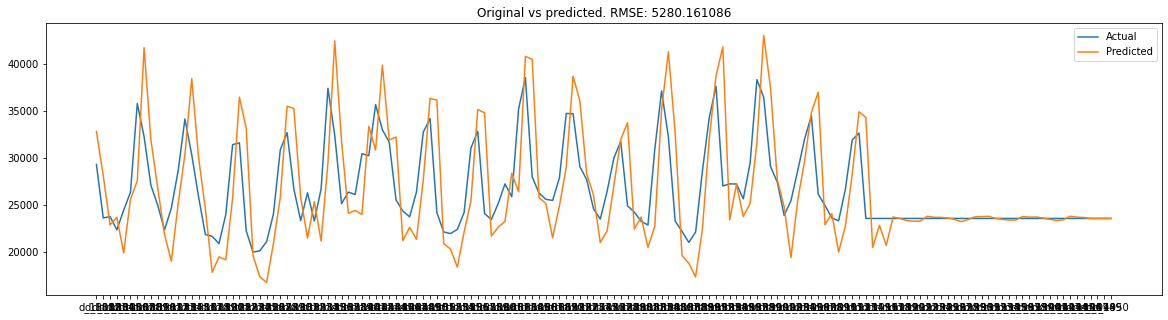

In [37]:
predictions_ARIMA_final = pd.Series(food_Series.at['d_2'],index=food_Series.index)
shfited.loc['d_1'] = 0
shfited.loc['d_2'] = 0
movingAverage.fillna(0)
predictVsActual = pd.DataFrame({'actual':food_Series,'diffMean':foodSeriesDiff,
                                'predictDiffOri':shfited['predicShfited2'],
                                'predictDiff':shfited['predicShfited2'],
                                'base':movingAverage})
predictVsActual['predict'] = predictVsActual.loc[:,['predictDiff','base']].sum(axis=1)
predictVsActual['error'] = predictVsActual['actual'] - predictVsActual['predict']
plt.figure(figsize=(20,5))
plt.plot(predictVsActual['actual'].iloc[1800:1950],label='Actual')
plt.plot(predictVsActual['predict'].iloc[1800:1950],label='Predicted')
#plt.plot(predictVsActual[['actual','predict']])
plt.legend(loc='best')
plt.title('Original vs predicted. RMSE: %4f'%np.sqrt(sum(predictVsActual['error']**2)/len(predictVsActual)))
plt.show()

#### Conclusion about ARIMA Model

ARIMA model took the longest to run and hence we decided to move on to other models for better performance efficiency.
The WRMSE score for ARIMA was 1.07

### LSTM: Long Short Term Memory - Recurrent Neural Networks

#### Reading data

In [38]:
calendar=pd.read_csv("calendar.csv")
sales=pd.read_csv("sales_train_evaluation.csv")
prices=pd.read_csv("sell_prices.csv")


#### Data Preparation

Timesteps of 14 days added to use past 14 days sales for prediction \
first 350 days ignored for analysis since they contain a lot of null values

In [40]:
timesteps = 14
startDay = 350

For reducing memory usage

In [42]:
def downcast(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [43]:
sales = downcast(sales)

Days for rows and 30490 items (all items of all stores) taken as columns

In [44]:
sales = sales.T    
sales.head(8)

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,HOBBIES_1_010,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,...,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3
cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,...,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
store_id,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,...,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3
state_id,CA,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,WI,WI,WI,WI,WI,WI,WI,WI,WI,WI
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0


Remove the first six columns id, item_id, dept_id, cat_id, store_id, state_id columns, with only days as rows

In [45]:
sales = sales[6 + startDay:]
sales.head(5)

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
d_351,0,0,0,2,0,0,0,24,3,2,...,0,9,1,0,11,0,0,1,0,0
d_352,0,0,0,0,0,0,0,9,0,2,...,0,5,4,0,8,0,1,2,0,0
d_353,0,0,0,4,2,0,0,2,1,1,...,0,15,2,0,3,0,1,2,0,0
d_354,0,1,0,2,0,0,0,7,1,0,...,0,5,1,0,3,0,0,0,0,0
d_355,0,0,0,1,2,0,0,0,0,0,...,0,7,1,0,1,0,1,1,0,0


Creating a dataframe with zeros for 1969 days in the calendar \
'daysBeforeEvent' will be a feature used for prediction

In [46]:
daysBeforeEvent = pd.DataFrame(np.zeros((1969,1)))

for the days before event_name_1, 1 is assigned. event_name_2 is skipped since it is rare

In [48]:
for x,y in calendar.iterrows():
    if((pd.isnull(calendar["event_name_1"][x])) == False):
           daysBeforeEvent[0][x-1] = 1 

In [49]:
#'daysBeforeEventTest' is used as input for predicting (We will forecast the days 1913-1941)
daysBeforeEventTest = daysBeforeEvent[1941:1969]
#'daysBeforeEvent' will be used for training
daysBeforeEvent = daysBeforeEvent[startDay:1941]

In [50]:
print(daysBeforeEvent.shape)
print(sales.shape)

(1591, 1)
(1591, 30490)


In [51]:
daysBeforeEvent.columns = ["oneDayBeforeEvent"]
daysBeforeEvent.index = sales.index

In [52]:
daysBeforeEvent.head()

,oneDayBeforeEvent
d_351,0.00
d_352,1.00
d_353,0.00
d_354,0.00
d_355,0.00


In [53]:
#Concatenatung 'daysBeforeEvent' feature with sales
sales = pd.concat([sales, daysBeforeEvent], axis = 1)
sales.head()

,0,1,2,3,4,5,6,7,8,9,...,30481,30482,30483,30484,30485,30486,30487,30488,30489,oneDayBeforeEvent
d_351,0,0,0,2,0,0,0,24,3,2,...,9,1,0,11,0,0,1,0,0,0.00
d_352,0,0,0,0,0,0,0,9,0,2,...,5,4,0,8,0,1,2,0,0,1.00
d_353,0,0,0,4,2,0,0,2,1,1,...,15,2,0,3,0,1,2,0,0,0.00
d_354,0,1,0,2,0,0,0,7,1,0,...,5,1,0,3,0,0,0,0,0,0.00
d_355,0,0,0,1,2,0,0,0,0,0,...,7,1,0,1,0,1,1,0,0,0.00


Feature Scaling 

In [54]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
sales_df_scaled = sc.fit_transform(sales)

C:\Users\nsagn\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\nsagn\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [56]:
X_train = []
y_train = []
for i in range(timesteps, 1941 - startDay):
    X_train.append(sales_df_scaled[i-timesteps:i])
    y_train.append(sales_df_scaled[i][0:30490]) 

In [57]:
#Convert to np array to be able to feed the LSTM model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)


(1577, 14, 30491)
(1577, 30490)


#### LSTM Model

LSTM is a type of RNN which is capable of learning order dependence for sequence predictions

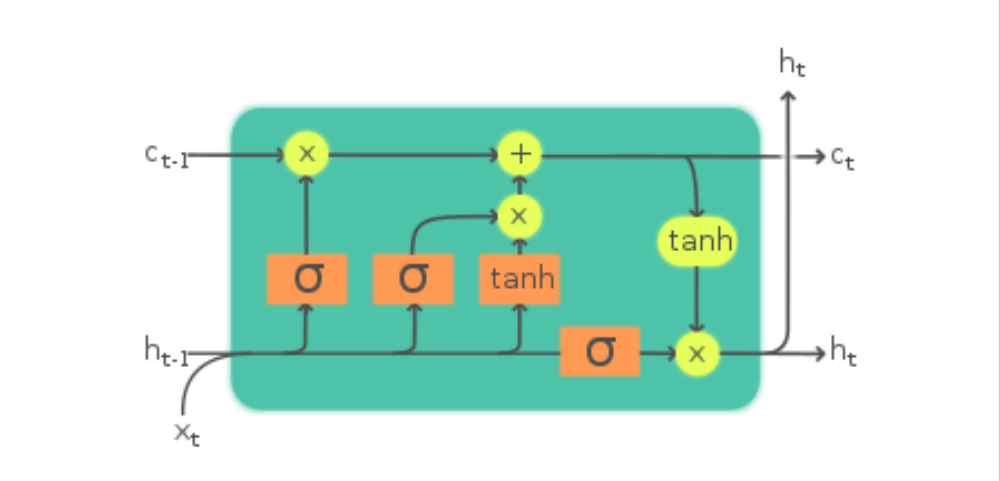

In [64]:
# Importing libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor.add(LSTM(units = layer_1_units,return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
layer_2_units=400
regressor.add(LSTM(units = layer_2_units, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 30490))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=50
batch_size_RNN=44
history=regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size_RNN, verbose=1)

Epoch 1/50
36/36 [==============================] - 55s 860ms/step - loss: 0.0180
Epoch 2/50
36/36 [==============================] - 31s 868ms/step - loss: 0.0157
Epoch 3/50
36/36 [==============================] - 30s 837ms/step - loss: 0.0152
Epoch 4/50
36/36 [==============================] - 29s 809ms/step - loss: 0.0149
Epoch 5/50
36/36 [==============================] - 29s 795ms/step - loss: 0.0147
Epoch 6/50
36/36 [==============================] - 29s 797ms/step - loss: 0.0146
Epoch 7/50
36/36 [==============================] - 29s 820ms/step - loss: 0.0144
Epoch 8/50
36/36 [==============================] - 29s 818ms/step - loss: 0.0143
Epoch 9/50
36/36 [==============================] - 29s 810ms/step - loss: 0.0142
Epoch 10/50
36/36 [==============================] - 30s 837ms/step - loss: 0.0141
Epoch 11/50
36/36 [==============================] - 31s 876ms/step - loss: 0.0139
Epoch 12/50
36/36 [==============================] - 32s 886ms/step - loss: 0.0139
Epoch 13/50
3

In [60]:
inputs= sales[-timesteps:]
inputs = sc.transform(inputs)

C:\Users\nsagn\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


#### Doing predictions

In [61]:
X_test = []
X_test.append(inputs[0:timesteps])
X_test = np.array(X_test)
predictions = []

for j in range(timesteps,timesteps + 28):
    predicted_stock_price = regressor.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 30491))
    testInput = np.column_stack((np.array(predicted_stock_price), daysBeforeEventTest[0][1941 + j - timesteps]))
    X_test = np.append(X_test, testInput).reshape(1,j + 1,30491)
    predicted_stock_price = sc.inverse_transform(testInput)[:,0:30490]
    predictions.append(predicted_stock_price)

1/1 [==============================] - 0s 63ms/step


#### Creation of submission file

In [62]:
import time

submission = pd.DataFrame(data=np.array(predictions).reshape(28,30490))

submission = submission.T
    
submission = pd.concat((submission, submission), ignore_index=True)

sample_submission = pd.read_csv("sample_submission.csv")
    
idColumn = sample_submission[["id"]]
    
submission[["id"]] = idColumn  

cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]

colsdeneme = ["id"] + [f"F{i}" for i in range (1,29)]

submission.columns = colsdeneme

currentDateTime = time.strftime("%d%m%Y_%H%M%S")

submission.to_csv("submission_3.csv", index=False)

In [63]:
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.84,0.67,0.76,0.87,0.89,1.39,1.56,0.85,0.78,...,0.67,0.84,0.91,0.71,0.68,0.60,0.59,0.59,0.75,0.91
1,HOBBIES_1_002_CA_1_validation,0.48,0.50,0.40,0.34,0.42,0.39,0.38,0.35,0.42,...,0.34,0.74,0.59,0.41,0.37,0.37,0.44,0.62,0.83,0.38
2,HOBBIES_1_003_CA_1_validation,0.44,0.33,0.49,0.69,0.91,1.02,0.84,0.38,0.33,...,0.61,1.04,0.83,0.55,0.51,0.59,0.68,0.82,1.27,1.06
3,HOBBIES_1_004_CA_1_validation,1.72,1.48,1.39,1.58,1.53,2.33,3.43,1.34,1.35,...,1.18,1.79,3.67,1.81,1.51,1.43,1.66,1.64,2.00,3.27
4,HOBBIES_1_005_CA_1_validation,0.74,0.71,1.03,1.41,1.43,1.55,1.81,1.40,1.41,...,1.25,1.51,2.19,1.03,0.98,1.08,1.29,1.25,1.50,1.77


#### Conclusion about LSTM Model

For LSTM, we received a WRMSE score of 0.82. 

### Sequence to Sequence Model

In this section, we try an approach to run the Seq2Seq model. We understand that this model takes a long time and heavy computational resources are required to execute this model, so we try to break down our problem and use two different techniques to run the model

- We first roll up on a store level and find the proportion of sales that were made for each product. As we have about 3000 products, we will have 3000 columns for each day per store in our dataset
- Next we use these proportions to create a vector of 3000 product proportions and use them as the input to our Sequence 2 Sequence model
- We shall use this Sequence 2 Sequence model to predict the product proportion for each store for the next 28 days
- Simultaneously we roll up the data on a store level for total product sales as well. We then use one of the boosting techniques namely LightGBM to predict the total sales for the next 28 days
- Finally what we would need to do is to combine both these predictions by multiplying the total store sales with the proportion of product sales to finally get item and store level product sales for each store for the next 28 days


#### Functions to help us create the input layer

In [ ]:
# create df on store level
def get_df1(store):
  pocdf = df_sales[(df_sales.store_id==store)]
  dcol = pocdf.columns
  dcol[pd.Series(pocdf.columns).str.startswith('d_', na=False)]
  date_list2 = dcol[pd.Series(pocdf.columns).str.startswith('d_', na=False)]
  pocdft = pd.melt(pocdf, id_vars=['item_id', 'store_id'], value_vars=date_list2,
                  var_name='day', value_name='sale')
  pocdftt = pocdft.pivot(index=['store_id','day'], columns='item_id', values='sale')
  df1 = pocdftt.reset_index()
  return df1

In [ ]:
# Creating the Proportion DF
def create_prop_df(df1):
  l = ['store_id','day']
  item_list_full = [x for x in df1.columns.to_list() if x not in l]

  df1[item_list_full] = df1[item_list_full].apply(lambda x: x/x.sum(), axis=1)
  df1 = df1.fillna(0)

  df1[['d','oday']] = df1['day'].str.split("_", expand=True)
  df1 = df1.drop(columns=['d'])
  df1['oday'] = df1.oday.astype(int)
  df2 = df1.sort_values('oday')
  return df2, item_list_full

In [ ]:
# define vars for Seq2Seq

def s2s_vars(df2):
  pred_length = 28
  first_day = df2.oday.min() 
  last_day = df2.oday.max()

  val_pred_start = last_day - pred_length + 1
  val_pred_end = last_day

  train_pred_start = val_pred_start - pred_length
  train_pred_end = val_pred_start - 1

  enc_length = train_pred_start - first_day

  train_enc_start = first_day
  train_enc_end = train_enc_start + enc_length - (1)

  val_enc_start = train_enc_start + pred_length
  val_enc_end = val_enc_start + enc_length - (1) 

  return pred_length, first_day, last_day, val_pred_start, val_pred_end, \
  train_pred_start, train_pred_end, enc_length, train_enc_start, train_enc_end, \
  val_enc_start, val_enc_end

In [ ]:
def get_time_block_series(series_array, start_date, end_date):
    return series_array[start_date:end_date]

In [ ]:
# Creating the Seq2Seq Model
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
import tensorflow as tf

Now we define the model architecture. Seq2Seq models have an encoder and a decoder that takes each input step wise to produce the output using LSTM cells

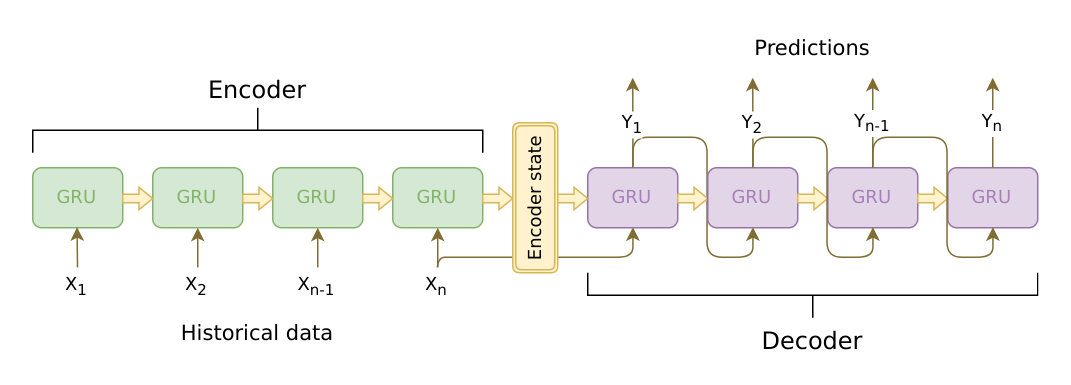

In [ ]:
def model_def():
    latent_dim = 50 # LSTM hidden units
    dropout = .20 
    # Define an input series and encode it with an LSTM. 
    encoder_inputs = Input(shape=(None, 3049)) 
    encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the final states. These represent the "context"
    # vector that we use as the basis for decoding.
    encoder_states = [state_h, state_c]
    # Set up the decoder, using `encoder_states` as initial state.
    # This is where teacher forcing inputs are fed in.
    decoder_inputs = Input(shape=(None, 3049)) 
    # We set up our decoder using `encoder_states` as initial state.  
    # We return full output sequences and return internal states as well. 
    # We don't use the return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                        initial_state=encoder_states)
  
    decoder_dense = Dense(3049) # 3049 continuous output at each timestep
    decoder_outputs = decoder_dense(decoder_outputs)
  
    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  
    model.summary()
    return model, encoder, decoder_lstm, encoder_inputs, encoder_states, decoder_inputs

In [ ]:
def enc_dec_data(df2, item_list_full, train_enc_start, train_enc_end, train_pred_start, train_pred_end):
    batch_size = 2**11
    epochs = 100
    series_array = df2[item_list_full].values
  
    # sample of series from train_enc_start to train_enc_end  
    encoder_input_data = get_time_block_series(series_array, 
                                              train_enc_start, train_enc_end)
    #encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    print("Input data shape:", encoder_input_data.shape)
  
    # sample of series from train_pred_start to train_pred_end 
    decoder_target_data = get_time_block_series(series_array, 
                                                train_pred_start, train_pred_end)
    #decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    print("Decoder Target data shape:", decoder_target_data.shape)
  
    # lagged target series for teacher forcing
    decoder_input_data = np.zeros(decoder_target_data.shape)
    decoder_target_data[:-1,:]
    decoder_input_data[1:,:] = decoder_target_data[:-1,:]
    decoder_input_data[0,:]
    encoder_input_data[-1,:]
    decoder_input_data[0,:] = encoder_input_data[-1,:]
  
    print("Decoder Input data shape:", decoder_input_data.shape)
    encoder_input_data = np.expand_dims(encoder_input_data, axis=0)
    print("encoder input data shape for Model training:", encoder_input_data.shape)
  
    decoder_target_data = np.expand_dims(decoder_target_data, axis=0)
    print("decoder target data shape for Model training:",decoder_target_data.shape)
  
    decoder_input_data = np.expand_dims(decoder_input_data, axis=0)
    print("decoder input data shape for Model training:",decoder_input_data.shape)
    return encoder_input_data, decoder_target_data, decoder_input_data

The architecture is defined we can move on to compiling and training the model. The below functions define the model help in ompiling and training steps. In addition to that they also define the steps for encoding and decoding the model in a sequence to sequence fashion

In [ ]:
# Model compilation and Training
def compile_train_model(model, encoder_input_data, decoder_input_data, decoder_target_data, batch_size, epochs):
    model.compile(Adam(), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                        batch_size=batch_size,
                        epochs=epochs)
    return(model, history)

In [ ]:
def encoding(encoder_inputs, encoder_states, latent_dim, decoder_inputs, decoder_lstm):
    pred_steps = 28
    # from our previous model - mapping encoder sequence to state vectors
    encoder_model = Model(encoder_inputs, encoder_states)
  
    # A modified version of the decoding stage that takes in predicted target inputs
    # and encoded state vectors, returning predicted target outputs and decoder state vectors.
    # We need to hang onto these state vectors to run the next step of the inference loop.
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
  
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                          [decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model


def decode_sequence(input_seq, encoder_model,pred_steps,decoder_model):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 3049))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0] = input_seq[0, -1]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,3049))
    
    for i in range(pred_steps):
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i] = output[0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 3049))
        target_seq[0, 0] = output[0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

We then move on to creating the inputs in the required manner for the sequence to sequence model and then execute the sequence to sequence model for all the 10 stores. The below section code does exactly that

In [ ]:
#empty df
cols = np.append(df_sales.item_id.unique(),['store_id','pred_day'])
mrdf = pd.DataFrame(columns=cols)

# function to call the model for each store and do predictions
for store in df_sales.store_id.unique():
    pred_steps = 28
    print(store)
    df1 = get_df1(store)
    
    df2, item_list_full = create_prop_df(df1)
    
    pred_length, first_day, last_day, val_pred_start, val_pred_end, train_pred_start, train_pred_end, enc_length, train_enc_start, train_enc_end, val_enc_start, val_enc_end = s2s_vars(df2)
    # Lets look at these periods
    print('Train encoding:', train_enc_start, '-', train_enc_end)
    print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
    print('Val encoding:', val_enc_start, '-', val_enc_end)
    print('Val prediction:', val_pred_start, '-', val_pred_end)

    print('\nEncoding interval:', enc_length)
    print('Prediction interval:', pred_length)
    
    model, encoder, decoder_lstm, encoder_inputs, encoder_states, decoder_inputs =  model_def()

    encoder_input_data, decoder_target_data, decoder_input_data = enc_dec_data(df2, item_list_full, train_enc_start, train_enc_end, train_pred_start, train_pred_end)

    batch_size = 2**11
    epochs = 100
    model, history = compile_train_model(model, encoder_input_data, decoder_input_data, decoder_target_data, batch_size, epochs)

#  plot_rmse(history)
    decoder_dense = Dense(3049)
    latent_dim = 50 # LSTM hidden units
    dropout = .20 
  
    encoder_model, decoder_model = encoding(encoder_inputs, encoder_states, latent_dim, decoder_inputs, decoder_lstm)
  
    result = decode_sequence(encoder_input_data, encoder_model,pred_steps,decoder_model)
    result1 = result
  
    r1 = result1[0,:, :]
    print(r1.shape)
  
    rdf = pd.DataFrame(r1, columns=item_list_full)
    rdf['store_id'] = store
    rdf['pred_day'] = range(1,29)
  
    mrdf = pd.concat([mrdf, rdf])

CA_1
Train encoding: 1 - 1885
Train prediction: 1886 - 1913 

Val encoding: 29 - 1913
Val prediction: 1914 - 1941

Encoding interval: 1885
Prediction interval: 28
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3049)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3049)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm (LSTM)                  

In [ ]:
mrdf.to_csv('prop_df.csv',index = False)

Source: https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb

- Above code takes about 120 minutes to execute for all 10 stores. 
- The output we get is a 3000 vector which is the proportion of each product sales for each store for the next 28 days which then is converted into a data frame and stored in the variable mrdf
- This data frame will next be used with the total sales of each store to get the actual unit sales values


In [5]:
sales_df = pd.read_pickle('/kaggle/input/finaldata2/final_data_2.pkl')

In [6]:
sales_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_27,lag_28,...,High_Spending_Month,Low_Spending_Month,sell_price_x,price_change_1,price_change_365,rolling_price_std_t7,rolling_price_std_t30,lag_revenue_t1,rolling_revenue_std_t28,rolling_revenue_mean_t28
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,8.281250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,3.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,2.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,4.339844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,2.480469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52442795,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,0,0.0,1.0,...,0,1,2.980469,0.0,0.0,0.000000e+00,0.0,2.980469,2.462343,1.916016
52442796,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,0,0.0,0.0,...,0,1,2.480469,0.0,0.0,0.000000e+00,0.0,0.000000,1.325866,0.708705
52442797,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,0,0.0,2.0,...,0,1,3.980469,0.0,0.0,4.301595e-09,0.0,7.960938,3.650916,3.127511
52442798,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,0,0.0,0.0,...,0,1,1.280273,0.0,0.0,0.000000e+00,0.0,0.000000,1.673035,1.691790


The helper functions in the below section are defined to create splits between the data set for obtain and validation, and also prepare the data in the format required for us to use it as total sales predictions which can then be multiplied with the proportion of product sales to get the final predictions

In [9]:
def model_tuning(sales_df):
    x_train = sales_df[sales_df["d"] < 1914].drop(["demand"], axis=1)
    x_val =  sales_df[(sales_df['d']>=1914) & (sales_df['d']<=1941)].drop(['demand'],axis=1)
    x_test = sales_df[sales_df["d"] >= 1942].drop(["demand"], axis=1)

    y_train = sales_df[sales_df["d"] < 1914]["demand"]
    y_val = sales_df[(sales_df['d']>=1914) & (sales_df['d']<=1941)]["demand"]
    return x_train,x_val,x_test,y_train,y_val

In [10]:
def submission_prep(x_val,x_test,pred_val,pred,sales_df):
    
    x_val['demand_pred'] = pred_val
    x_test['demand_pred'] = pred
    
    #x_val['item_id'] = sales_df[(sales_df['d'] > 1913) & (sales_df['d'] < 1942) ]['item_id']
    #x_test['item_id'] = sales_df[sales_df['d'] > 1941]['item_id']
    
    x_val['store_id'] = x_val['store_id'].astype('str')
    #x_val['item_id'] = x_val['item_id'].astype('str')
    x_val['id'] = x_val['store_id'] + '_validation'
    
    x_test['store_id'] = x_test['store_id'].astype('str')
    #x_test['item_id'] = x_test['item_id'].astype('str')
    x_test['id'] = x_test['store_id'] + '_evaluation'
    
    final_submission_2 = x_val.pivot(index = 'id',columns = 'd',values = 'demand_pred')
    final_submission = x_test.pivot(index = 'id',columns = 'd',values = 'demand_pred')
    
    li = ['id']
    for i in range(1,29):
        li.append('F'+str(i))
        
    final_submission = final_submission.reset_index()
    final_submission.columns = li
    
    final_submission_2 = final_submission_2.reset_index()
    final_submission_2.columns = li
    
    final_submission = pd.concat([final_submission,final_submission_2])
    
    return final_submission

In [11]:
def downcast(df):
    
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i,t in enumerate(types):

        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')

    return df  

In [12]:
sales_df = downcast(sales_df)

In [15]:
store_df = sales_df.groupby(['store_id','d']).apply(lambda x: x.sum())
store_df

d  demand  lag_27  lag_28  lag_29  lag_30  \
store_id d                                                         
CA_1     250    762250.0  2798.0     0.0     0.0     0.0     0.0   
         251    765299.0  2690.0     0.0     0.0     0.0     0.0   
         252    768348.0  3541.0     0.0     0.0     0.0     0.0   
         253    771397.0  4604.0     0.0     0.0     0.0     0.0   
         254    774446.0  4417.0     0.0     0.0     0.0     0.0   
...                  ...     ...     ...     ...     ...     ...   
WI_3     1965  5991285.0     0.0  3398.0  3268.0  3306.0  3896.0   
         1966  5994334.0     0.0  4128.0  3398.0  3268.0  3306.0   
         1967  5997383.0     0.0  4520.0  4128.0  3398.0  3268.0   
         1968  6000432.0     0.0  4756.0  4520.0  4128.0  3398.0   
         1969  6003481.0     0.0     0.0  4756.0  4520.0  4128.0   

               rolling_mean_7_28  rolling_std_7_28  rolling_mean_30_28  \
store_id d                                                               
CA_1     250                 0.0               0.0                 0.0   
         251                 0.0               0.0                 0.0   
         252                 0.0               0.0                 0.0   
         253                 0.0               0.0                 0.0   
         254                 0.0               0.0                 0.0   
...                          ...               ...                 ...   
WI_3     1965             4288.0            3408.0              4018.0   
         1966             4204.0            3414.0              4020.0   
         1967             4224.0            3432.0              4052.0   
         1968             4058.0            3342.0              4096.0   
         1969             3896.0            3194.0              4128.0   

               rolling_std_30_28  ...  High_Spending_Month  \
store_id d                        ...                        
CA_1     250                 0.0  ...                  0.0   
         251                 0.0  ...                  0.0   
         252                 0.0  ...                  0.0   
         253                 0.0  ...                  0.0   
         254                 0.0  ...                  0.0   
...                          ...  ...                  ...   
WI_3     1965             3624.0  ...                  0.0   
         1966             3624.0  ...                  0.0   
         1967             3626.0  ...                  0.0   
         1968             3656.0  ...                  0.0   
         1969             3674.0  ...                  0.0   

               Low_Spending_Month  sell_price_x  price_change_1  \
store_id d                                                        
CA_1     250                  0.0       13488.0        0.000000   
         251                  0.0       13488.0        0.000000   
         252                  0.0       13488.0        0.000000   
         253                  0.0       13488.0       -1.438477   
         254                  0.0       13488.0        0.000000   
...                           ...           ...             ...   
WI_3     1965              3049.0       13704.0        0.000000   
         1966              3049.0       13704.0        0.000000   
         1967              3049.0       13704.0        0.000000   
         1968              3049.0       13712.0       -2.781250   
         1969              3049.0       13712.0        0.000000   

               price_change_365  rolling_price_std_t7  rolling_price_std_t30  \
store_id d                                                                     
CA_1     250           0.000000              0.000000               0.000000   
         251           0.000000              0.000000               0.000000   
         252           0.000000              0.000000               0.000000   
         253           0.000000              0.000000               0.000000   
         254    

In [16]:
store_df1 = store_df.drop(columns='d').reset_index()

We use lightGBM for this prediction task given its optimal execution time and performance. The parameters that we use are Twitter distribution as our objective function and .075 as our learning rate

In [18]:
params = {
          "objective" : "tweedie",
          "metric" :"rmse",
          "force_row_wise" : True,
          "learning_rate" : 0.075,
          "sub_row" : 0.75,
          "bagging_freq" : 1,
          "lambda_l2" : 0.1,
          "metric": ["rmse"],
          'verbosity': 0,
          'num_iterations' : 1200,
          'num_leaves': 128,
          "min_data_in_leaf": 100,
         }

In [21]:
df = store_df1[store_df1['store_id'] == 'CA_1']
x_train,x_val,x_test,y_train,y_val = model_tuning(df)
x_train.shape

(1664, 34)

This function here executes our LightGBM model training

In [ ]:
final_sub = pd.DataFrame()
for j in range(len(stores)):
    df = store_df1[(store_df1['store_id'] == stores[j])]
    x_train,x_val,x_test,y_train,y_val = model_tuning(df)
    

    trainData = lgb.Dataset(x_train, label = y_train, free_raw_data = False)
    validData = lgb.Dataset(x_val, label = y_val, free_raw_data = False)
    
    m_lgb = lgb.train(params, trainData, valid_sets = [validData], verbose_eval = 2,early_stopping_rounds = 200) 
    
    pred_val = m_lgb.predict(x_val)
    pred = m_lgb.predict(x_test)
    
    print(stores[j],mean_squared_error(y_val,pred_val,squared = False))
    
    final_sub_2 = submission_prep(x_val,x_test,pred_val,pred,df)
    
    if len(final_sub) != 0:
        final_sub = pd.concat([final_sub_2,final_sub])
    else:
        final_sub = final_sub_2

In [28]:
final_sub.to_csv('StorePred_Result.csv',index = False)

Now we work to combine the predictions

In [34]:
store_pred = pd.read_csv('StorePred_Result_eval.csv')
prop_df = pd.read_csv('prop_df.csv')

In [35]:
store_pred

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,WI_3,3222.111563,3162.198448,2875.566429,2847.735519,3377.162697,4011.606478,3934.523432,3174.261072,3373.079157,...,3732.322644,4929.991431,4832.513213,3423.845343,3777.029362,3652.404788,3420.315658,3718.525604,4489.403345,4544.108564
1,WI_2,4455.900031,4355.709756,4020.276665,4130.633685,4785.098428,5220.987383,4920.555562,4605.396874,4605.396874,...,5262.821362,6591.164387,6286.263543,4957.203623,5511.018144,5613.430307,4565.717793,4822.647790,5562.781624,4976.591809
2,WI_1,3192.161465,3041.606985,2998.847451,3251.877753,3895.339742,5008.158351,4453.480082,3116.440970,3046.553273,...,3914.888990,4901.647689,4647.225762,3363.682695,3350.022900,3403.923477,3497.587514,3960.492093,5055.785220,4388.127744
3,TX_3,3568.681763,3364.927274,3317.864766,3360.087077,3540.963313,4228.725790,4160.239540,3529.921621,3545.967303,...,3825.282709,4573.811206,4559.264803,4154.492312,3739.047920,3942.412194,3489.240421,3713.086595,4492.337161,4355.723217
4,TX_2,3568.669299,3553.456882,3355.645744,3392.834035,3649.050542,4424.168143,4599.410144,3596.941360,3400.238991,...,3976.514529,4941.010276,5005.767979,4221.923576,3738.473812,3981.208053,3576.541001,3897.647350,4800.651924,4842.309308
5,TX_1,3076.502305,2923.506126,2644.020366,2669.817567,3068.456771,3846.870217,4006.702546,2921.228712,2763.420276,...,3214.627356,4114.733641,4144.800757,3480.231883,3284.894714,3250.681470,2975.172847,3230.188113,3913.857225,4070.103284
6,CA_4,2676.638418,2610.515654,2495.643042,2503.029038,2501.896707,2885.424141,3010.607972,2695.147202,2679.718425,...,2616.368402,2947.723215,3028.599819,2704.967060,2699.555541,2592.871524,2545.626166,2596.995943,2991.512009,2845.058310
7,CA_3,6251.857986,5669.247095,5311.674478,5324.125209,5542.218995,6721.175381,7081.769368,6072.799207,5858.645202,...,6420.657870,7046.417416,7681.920515,6384.867074,6007.751998,5797.152403,5837.797476,6085.578030,7159.463752,7426.311507
8,CA_2,4015.643327,3657.441279,3697.039702,4059.351363,4481.698882,5768.895215,5758.966284,4355.456541,4176.785387,...,4516.748433,6037.447950,5840.133231,4122.943469,4011.389808,3911.403806,4097.560024,4433.622686,5709.593915,5579.815894
9,CA_1,4422.367037,3857.427345,3632.469624,3665.752831,4195.838958,5588.438723,5925.591475,4517.831262,4226.266120,...,4710.269059,5701.847064,5948.270198,4434.978390,4114.064014,4012.962212,4094.931989,4334.532454,5720.261096,5693.067076


In [36]:
col_list = store_pred.columns
col_list = [x for x in col_list if x not in ['id']]
store_list = store_pred['id'].unique()
store_list = store_list.tolist()

In [44]:
prop_df

,Unnamed: 0,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,...,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827,store_id,pred_day
0,0,0.000065,0.000138,0.000075,0.000022,-0.000117,0.000054,0.000165,-0.000121,-0.000121,...,0.000133,-0.000013,1.161782e-05,-0.000244,0.000172,-0.000102,-0.000112,-0.000200,CA_1,1
1,1,0.000080,0.000200,0.000105,0.000048,-0.000128,0.000041,0.000195,-0.000084,-0.000075,...,0.000063,0.000007,-7.813633e-06,-0.000221,0.000212,-0.000085,-0.000115,-0.000169,CA_1,2
2,2,0.000094,0.000242,0.000146,0.000069,-0.000137,0.000028,0.000216,-0.000069,-0.000038,...,0.000008,0.000023,-1.835694e-05,-0.000200,0.000239,-0.000068,-0.000119,-0.000143,CA_1,3
3,3,0.000106,0.000269,0.000190,0.000085,-0.000145,0.000016,0.000230,-0.000068,-0.000009,...,-0.000033,0.000036,-2.058305e-05,-0.000181,0.000256,-0.000051,-0.000126,-0.000121,CA_1,4
4,4,0.000116,0.000285,0.000233,0.000097,-0.000150,0.000004,0.000240,-0.000075,0.000011,...,-0.000065,0.000046,-1.619228e-05,-0.000164,0.000266,-0.000035,-0.000133,-0.000103,CA_1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,23,0.000388,0.000066,0.000435,-0.000441,-0.000282,0.000205,-0.000083,-0.000609,0.000280,...,0.000140,0.000266,-2.764943e-06,-0.000373,0.000057,0.000376,0.000094,-0.000374,WI_3,24
276,24,0.000389,0.000065,0.000435,-0.000441,-0.000281,0.000205,-0.000082,-0.000610,0.000280,...,0.000141,0.000266,-8.431753e-07,-0.000373,0.000056,0.000376,0.000094,-0.000373,WI_3,25
277,25,0.000389,0.000065,0.000435,-0.000441,-0.000280,0.000206,-0.000081,-0.000611,0.000281,...,0.000142,0.000267,7.576989e-07,-0.000374,0.000055,0.000377,0.000095,-0.000373,WI_3,26
278,26,0.000389,0.000064,0.000435,-0.000440,-0.000279,0.000206,-0.000080,-0.000612,0.000281,...,0.000143,0.000267,2.079892e-06,-0.000374,0.000055,0.000378,0.000095,-0.000373,WI_3,27


In [ ]:
l = ['store_id','pred_day','Unnamed: 0']
item_list_full = [x for x in prop_df.columns.to_list() if x not in l]
prop_df1 = prop_df

for i in col_list:
    # print(i)
    for j in store_list:
        store_total_sale = store_pred[i][(store_pred['id'] == j)]
        # print(store_total_sale)
        # print(i[1:])
    day = i[1:]
    for k in item_list_full:
        prop_df1[(prop_df1['store_id'] == j) & (prop_df1['pred_day'] == day)][k] =  prop_df[(prop_df['store_id'] == j) & (prop_df['pred_day'] == day)][k] * store_total_sale

In [ ]:
prop_df1.to_csv('Seq2Seq.csv')

In [59]:
print(rmse)

1.5737002753096097


#### Conclusion about Seq2Seq Model
- The result of this Sequence 2 Sequence model is saved in a file called seq2seq.csv. 
- The RMSE of this prediction is 1.57 which is very high in comparison to the other models we tried. 
- While this technique is really beneficial to solve any time series prediction model we believe that in this specific scenario this model is not giving us the best performance what we desire

We shall now move on to the other techniques available using boosting. The first we try is XGBoost

### XGBoost Model

We decided to use a memory reduce function that we learned from a kaggle notebook. It helped us manage out data size and performance of the model.

In [5]:
#function to reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: 
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

sales_train_val = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
sales_df = reduce_mem_usage(sales_train_val)

cal = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
calendar_df = reduce_mem_usage(cal)

sell_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
prices = reduce_mem_usage(sell_prices)

submission = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv')
sample = reduce_mem_usage(submission)

Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)


We begin by preparing the data

In [6]:
#data prep
data = sales_df.iloc[:, pd.np.r_[0,-100:0]]
data = data.melt('id', var_name='d', value_name='demand')

data = data.merge(calendar_df)
media = data.groupby(['id','wday'])['demand'].mean()

# make a copy of the sample submission
sub = sample.copy()
# select only the rows with an id with the validation tag
sub.columns = ['id'] + ['d_' + str(1914+x) for x in range(28)]
sub = sub.loc[sub.id.str.contains('validation')]
sub = sub.melt('id', var_name='d', value_name='demand')

val_rows = len(sub)

In [8]:
val_rows

853720

We then prepare train and validation data sets

In [9]:
# 
y = data.demand
features = ['id', 'd', 'wday']
X_raw = data[features]

X = label(X_raw, ['id', 'd'])

X_train = X[:-val_rows]
X_valid  = X[-val_rows:]

y_train = y[:-val_rows]

In [10]:
# define model
from xgboost import XGBRegressor

# Define the model
my_model_2 = XGBRegressor(n_estimators = 1000, learning_rate = 0.05)

# Fit the model
my_model_2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [11]:
#prediction
preds_val = my_model_2.predict(X_valid)
sub['demand'] = preds_val
temp = sub.pivot(index='id', columns='d', values='demand')
temp.reset_index(inplace=True)

In [12]:
#prepare submission
submission = sample[['id']].copy()
submission = submission.merge(temp)
submission = pd.concat([submission, submission], axis=0)
submission['id'] = sample.id.values
submission.columns = ['id'] + ['F' + str(i) for i in range(1,29)]
submission.head()
submission.to_csv('submission.csv', index=False)

As mentioned below, our xgboost submission gave us an WRMSE score of 1.1. Overall, this was not a good score for us to go ahead with this model.

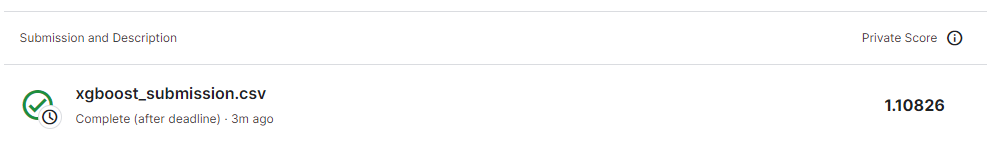

### LightGBM Model

This section contains the code for our best performing model - LightGBM. As is consistent we first load all the relevant libraries.

We load the pickle file that we had written into earlier from our feature engineering file. One reason for using pickle file is the lower amount of space it consumes while using these files. Further, it is also serializable.

In [3]:
sales_df = pd.read_pickle('/kaggle/input/features-extended/final_data (2).pkl')

We can now take a look at the first few records of the input file.

In [4]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_28,lag_29,...,High_Spending_Month,Low_Spending_Month,sell_price_x,price_change_1,price_change_365,rolling_price_std_t7,rolling_price_std_t30,lag_revenue_t1,rolling_revenue_std_t28,rolling_revenue_mean_t28
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,8.281250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,3.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,2.970703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,4.339844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,250,0,NaN,NaN,...,0,0,2.480469,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see above that there are few NaNs. This is expected as we had created lag features earlier. As lag features involve moving the data down across the time series by a few records - we expect this to be the case. We will consider updating our input by considering input after 350 days - to ensure there are no NaNs. Also analysis from the ARIMA model has shown that there is a lot of fluctuation until this point - so it would be better to consider the updated data. 

In [5]:
sales_df = sales_df[sales_df['d'] > 350]

As we move towards our modelling step - we will now take a look at the data types of each column

In [6]:
sales_df.dtypes

id                          category
item_id                     category
dept_id                     category
cat_id                      category
store_id                    category
state_id                    category
d                              int16
demand                         int16
lag_28                       float16
lag_29                       float16
lag_30                       float16
rolling_mean_7_28            float16
rolling_std_7_28             float16
rolling_mean_30_28           float16
rolling_std_30_28            float16
rolling_mean_90_28           float16
rolling_mean_180_28          float16
month                           int8
snap_CA                         int8
snap_TX                         int8
snap_WI                         int8
Religious_Holiday               int8
Cultural_Holiday                int8
Sporting_Holiday                int8
National_Holiday                int8
weekend                         int8
Month_End                       int8
M

We also write a function for splitting the input data to train, test and validation data. We will shortly explain the reason behind the usage of this function as well.

In [7]:
def model_tuning(sales_df):
    x_train = sales_df[sales_df["d"] < 1914].drop(["demand",'id'], axis=1)
    x_val =  sales_df[(sales_df['d']>=1914) & (sales_df['d']<=1941)].drop(['demand','id'],axis=1)
    x_test = sales_df[sales_df["d"] >= 1942].drop(["demand",'id'], axis=1)

    y_train = sales_df[sales_df["d"] < 1914]["demand"]
    y_val = sales_df[(sales_df['d']>=1914) & (sales_df['d']<=1941)]["demand"]
    return x_train,x_val,x_test,y_train,y_val

We then follow this up with another function which considers the predicted values, the validation and testing features - to then return a final pandas dataframe which would contain the results in the required format. We know that the days 1913-1941 are part of the validation phase as well as the days after 1941 are part of the unknown test phase. 

We then update the ID columns for each of these records. We follow this up by pivotting up the data - similar to the view of the sample submission file that came across in the Kaggle requirements. These two seperate pivotted tables are then combined together to return one pandas dataframe as our final submission file

In [8]:
def submission_prep(x_val,x_test,pred_val,pred,sales_df):
    
    x_val['demand_pred'] = pred_val
    x_test['demand_pred'] = pred
    
    x_val['item_id'] = sales_df[(sales_df['d'] > 1913) & (sales_df['d'] < 1942) ]['item_id']
    x_test['item_id'] = sales_df[sales_df['d'] > 1941]['item_id']
    
    x_val['store_id'] = x_val['store_id'].astype('str')
    x_val['item_id'] = x_val['item_id'].astype('str')
    x_val['id'] = x_val['item_id'] + '_' + x_val['store_id'] + '_validation'
    
    x_test['store_id'] = x_test['store_id'].astype('str')
    x_test['item_id'] = x_test['item_id'].astype('str')
    x_test['id'] = x_test['item_id'] + '_' + x_test['store_id'] + '_evaluation'
    
    final_submission_2 = x_val.pivot(index = 'id',columns = 'd',values = 'demand_pred')
    final_submission = x_test.pivot(index = 'id',columns = 'd',values = 'demand_pred')
    
    li = ['id']
    for i in range(1,29):
        li.append('F'+str(i))
        
    final_submission = final_submission.reset_index()
    final_submission.columns = li
    
    final_submission_2 = final_submission_2.reset_index()
    final_submission_2.columns = li
    
    final_submission = pd.concat([final_submission,final_submission_2])
    
    return final_submission

We continue to use the same Downcast function we had written earlier - to ensure that we consume lower space and there is less RAM used.

In [9]:
def downcast(df):
    
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i,t in enumerate(types):

        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')

    return df  

In [10]:
sales_df = downcast(sales_df)

Our first approach considers us taking a parameter grid - to estimate the best parameters. As suggested, we are considering the use of Bayesian optimiziation technique in this scenario. Bayesian Optimizer is among the best algorithms to return the best set of parameters to be used for our modelling approach - it might be slightly slower on ocassions when compared to Randomized Grid Search but ensures that it always returns the best parameters giving us the best results. 

In [11]:
# X_train,X_val,X_test,Y_train,Y_val = model_tuning(sales_df)

Below is the code we found for implementing the Bayesian Optimization. We have modified it to include the best parameters as required for us.

In [12]:
# from hyperopt import hp, tpe, fmin
# from lightgbm import LGBMRegressor as lgb_b
# from sklearn.model_selection import cross_val_score

# valgrid = {'n_estimators':hp.quniform('n_estimators', 1000, 1400, 100),
#            'learning_rate':hp.quniform('learning_rate', 0.01, 0.3, 0.03),
#            'num_leaves':hp.quniform('num_leaves', 200,2048,250),
#            'subsample':hp.quniform('subsample', 0.5, 0.9, 0.1),
#            'min_child_weight':hp.quniform('min_child_weight', 200, 500, 100) 
#           }

# def objective(params):
#     params = {'n_estimators': int(params['n_estimators']),
#               'learning_rate': params['learning_rate'],
#               'num_leaves': int(params['num_leaves']),
#               'subsample': params['subsample'],
#               'min_child_weight': params['min_child_weight']}
    
#     lgb_a = lgb_b(**params)
#     score = cross_val_score(lgb_a, X_train, Y_train, cv=2, n_jobs=-1).mean()
#     return score

# bestP = fmin(fn= objective, space= valgrid, max_evals=20, rstate=np.random.default_rng(123), algo=tpe.suggest)

The best parameters are as returned below.

In [13]:
# print(bestP)

However, as we faced frequent out of memory errors - we noted down the best parameters from above and then commented out the code to ensure that we do not have to run the entire notebook for a small change. 

We then follow this up by making a list of unique Department and store combinations. 

In [14]:
depts = list(sales_df['dept_id'].unique())

In [15]:
depts

['HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2',
 'FOODS_1',
 'FOODS_2',
 'FOODS_3']

In [16]:
stores = list(sales_df['store_id'].unique())

In [17]:
stores

['CA_1',
 'CA_2',
 'CA_3',
 'CA_4',
 'TX_1',
 'TX_2',
 'TX_3',
 'WI_1',
 'WI_2',
 'WI_3']

The reason for considering the combination above is that we noticed as highlighted in our EDA that there is a lot of variation at the department-store level. In order to avoid us making a large mistake at each iteration. We have decided to make the predictions at that level. 

We will now define the parameters that we had observed above. 

In [18]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'subsample': 0.5,
            'learning_rate': 0.03,
            'min_data_in_leaf': 2 ** 12 - 1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1200,
            'boost_from_average': False,
            'verbosity': -1
        }

Below is our code for predicting at store-department level. We have iterated through at each department-store level and then used our functions that we had defined above for both splitting the input data as well as combining our predictions.

In [19]:
final_sub = pd.DataFrame()
for i in range(len(depts)):
    for j in range(len(stores)):
        df = sales_df[(sales_df['dept_id'] == depts[i]) & (sales_df['store_id'] == stores[j])]
        x_train,x_val,x_test,y_train,y_val = model_tuning(df)
    
        catFeats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id','month','snap_CA',
                    'snap_TX','snap_WI','Religious_Holiday','Cultural_Holiday','Sporting_Holiday',
                    'National_Holiday','weekend','Month_End','Month_Start','Quarter',
                    'High_Spending_Month','Low_Spending_Month']

        trainData = lgb.Dataset(x_train, label = y_train, 
                        categorical_feature = catFeats, free_raw_data = False)
        validData = lgb.Dataset(x_val, label = y_val,
                        categorical_feature = catFeats, free_raw_data = False)
    
        m_lgb = lgb.train(params, trainData, valid_sets = [validData], verbose_eval = False,early_stopping_rounds = 50) 
    
        pred_val = m_lgb.predict(x_val)
        pred = m_lgb.predict(x_test)    
        final_sub_2 = submission_prep(x_val,x_test,pred_val,pred,df)
    
        if len(final_sub) != 0:
            final_sub = pd.concat([final_sub_2,final_sub])
        else:
            final_sub = final_sub_2

We then write this to a CSV file to enable Kaggle submissions

In [20]:
final_sub.to_csv('LightGBM - Best Performance.csv',index = False)

Below - we simplt have the code to generate a hyperlink for downloading.

In [21]:
import os
os.chdir(r'/kaggle/working')

In [22]:
from IPython.display import FileLink
FileLink(r'LightGBM - Best Performance.csv')

Finally below is the screenshot of our best Kaggle Submission of this model

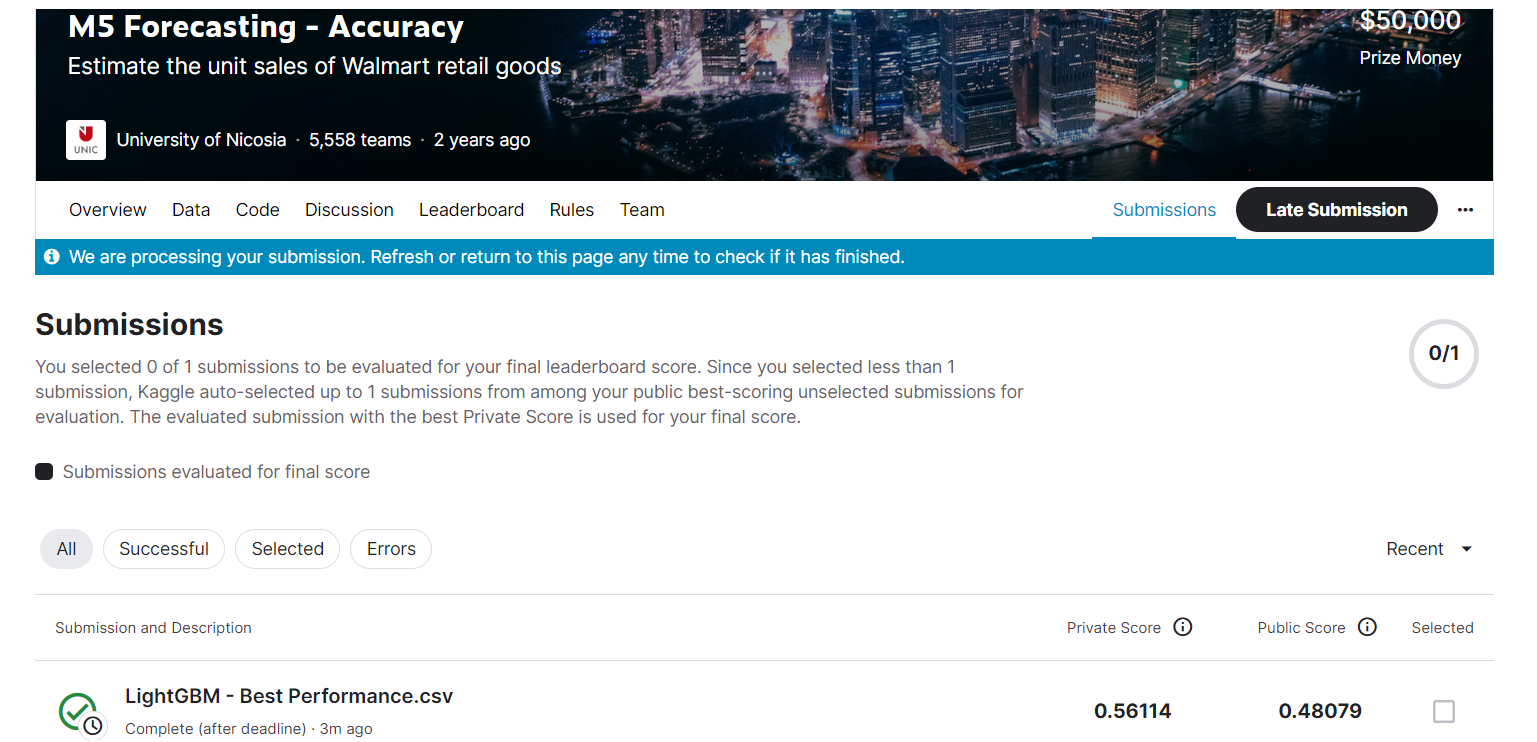